Documentación pyedflib: https://pyedflib.readthedocs.io/en/latest/ref/edfreader.html  
Documentación networkx: https://networkx.org/documentation/stable/reference/introduction.html  
Información grafos: https://www.cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python.html  
Información mne: https://mne.tools/stable/index.html  

In [1]:
import mne
import pyedflib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from os.path import basename
from pprint import pprint
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

CHANNELS: tuple[str] = ('Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 
                        'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 
                        'Fz', 'Cz', 'Pz')
N_CHANNELS: int = len(CHANNELS)

df_subject_info = pd.read_csv('Archivos\subject-info.csv')[['Subject', 'Count quality']]

# Posición aproximada de los electrodos en la cabeza
pos = {
    'Fp1': (-0.300, 0.954), 'Fp2': (0.300, 0.954),
    'F3': (-0.400, 0.510), 'F4': (0.400, 0.510),
    'F7': (-0.800, 0.600), 'F8': (0.800, 0.600),
    'T3': (-1.000, 0.000), 'T4': (1.000, 0.000),
    'C3': (-0.500, 0.000), 'C4': (0.500, 0.000),
    'T5': (-0.800, -0.600), 'T6': (0.800, -0.600),
    'P3': (-0.400, -0.510), 'P4': (0.400, -0.510),
    'O1': (-0.300, -0.954), 'O2': (0.300, -0.954),
    'Fz': (0.000, 0.500), 'Cz': (0.000, 0.000),
    'Pz': (0.000, -0.500)
}

In [3]:
# Convertir un archivo EDF a CSV

def edf_to_csv(filename: str, output_path: str = '') -> None:
    f: pyedflib.EdfReader = pyedflib.EdfReader(filename)
    
    signals: np.zeros = np.zeros((N_CHANNELS + 1, m:=f.getNSamples()[0]))
    signals[0, :] = np.arange(1, m + 1) # Es la cabecera de las columnas que son numeros desde el 1 al No. Señales
    for i in np.arange(1, N_CHANNELS + 1):
        signals[i, :]= f.readSignal(i - 1)

    np.savetxt(output_path + basename(filename.replace('.edf', '.csv')), signals, delimiter=';')

    f.close()

In [ ]:
def resize_all_subject_csv() -> None:
	# Cada indice representa 0.002 segundos del audio
	# Para el 4to sujeto: Antes->85000, Durante->31000
	# Para el 10mo sujeto: Antes->94000, Durante->31000
	# Para el 31vo sujeto: Antes->40000, Durante->31000
	# Para los demás sujetos: Antes->91000, Durante->31000

	for i in range(36):
		subject = f'Subject{i:02}'
		edf_path1 = f'Archivos\\{subject}\\edf\\{subject}_1.edf'
		edf_path2 = f'Archivos\\{subject}\\edf\\{subject}_2.edf'

		csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
		csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

		temp_raw_before = mne.io.read_raw_edf(edf_path1)
		temp_raw_during = mne.io.read_raw_edf(edf_path2)

		temp_raw_before.drop_channels(['EEG A2-A1', 'ECG ECG'])
		temp_raw_during.drop_channels(['EEG A2-A1', 'ECG ECG'])

		if i == 4:
			final_index = 84081
		elif i == 10:
			final_index = 93272
		elif i == 31:
			final_index = 39313
		else:
			final_index = 90000
		
		csv_data1 = np.concatenate([[np.arange(final_index)], temp_raw_before.get_data()[:, :final_index]])
		csv_data2 = np.concatenate([[np.arange(30000)], temp_raw_during.get_data()[:, :30000]])

		np.savetxt(csv_path1, csv_data1, delimiter=';')
		np.savetxt(csv_path2, csv_data2, delimiter=';')

In [28]:
df: pd.DataFrame = pd.read_csv(r'Archivos\Subject00\csv\Subject00_1.csv', sep=';')

df = np.transpose(df)
df.columns = CHANNELS

# Hacer la matriz de correlación
df.corr()

Fp1       Fp2        F3        F4        F7        F8        T3  \
Fp1  1.000000  0.934770  0.925696  0.865536  0.611838  0.754611  0.428443   
Fp2  0.934770  1.000000  0.764401  0.831179  0.488979  0.761121  0.292107   
F3   0.925696  0.764401  1.000000  0.816772  0.596539  0.629622  0.429035   
F4   0.865536  0.831179  0.816772  1.000000  0.508447  0.735990  0.335230   
F7   0.611838  0.488979  0.596539  0.508447  1.000000  0.412390  0.334690   
F8   0.754611  0.761121  0.629622  0.735990  0.412390  1.000000  0.221961   
T3   0.428443  0.292107  0.429035  0.335230  0.334690  0.221961  1.000000   
T4   0.428932  0.423059  0.475463  0.538910  0.260938  0.429680  0.342658   
C3   0.673122  0.544602  0.731825  0.624308  0.464262  0.474793  0.589535   
C4   0.667798  0.605387  0.679280  0.731591  0.394966  0.564996  0.440658   
T5   0.150640  0.063625  0.219881  0.143040  0.102571  0.028563  0.554805   
T6   0.028052  0.066901  0.088687  0.143229  0.004410  0.133597  0.158176   
P3   0.292105  0.207322  0.336892  0.291285  0.194612  0.187935  0.588918   
P4   0.156538  0.154852  0.231524  0.253038  0.080509  0.196880  0.322600   
O1   0.015742 -0.035255  0.044773  0.030957 -0.018995 -0.000456  0.298933   
O2  -0.184683 -0.159631 -0.138810 -0.106164 -0.154577 -0.098009  0.032305   
Fz   0.865648  0.831842  0.834020  0.941251  0.511843  0.748711  0.341100   
Cz   0.676511  0.569610  0.701509  0.671197  0.405079  0.503010  0.424516   
Pz   0.291741  0.230074  0.354772  0.320911  0.172486  0.238654  0.479727   

           T4        C3        C4        T5        T6        P3        P4  \
Fp1  0.428932  0.673122  0.667798  0.150640  0.028052  0.292105  0.156538   
Fp2  0.423059  0.544602  0.605387  0.063625  0.066901  0.207322  0.154852   
F3   0.475463  0.731825  0.679280  0.219881  0.088687  0.336892  0.231524   
F4   0.538910  0.624308  0.731591  0.143040  0.143229  0.291285  0.253038   
F7   0.260938  0.464262  0.394966  0.102571  0.004410  0.194612  0.080509   
F8   0.429680  0.474793  0.564996  0.028563  0.133597  0.187935  0.196880   
T3   0.342658  0.589535  0.440658  0.554805  0.158176  0.588918  0.322600   
T4   1.000000  0.525030  0.859688  0.344008  0.850169  0.543240  0.824333   
C3   0.525030  1.000000  0.716830  0.418020  0.241109  0.637078  0.453724   
C4   0.859688  0.716830  1.000000  0.298777  0.530274  0.595375  0.682318   
T5   0.344008  0.418020  0.298777  1.000000  0.223848  0.738296  0.413974   
T6   0.850169  0.241109  0.530274  0.223848  1.000000  0.453707  0.803271   
P3   0.543240  0.637078  0.595375  0.738296  0.453707  1.000000  0.727664   
P4   0.824333  0.453724  0.682318  0.413974  0.803271  0.727664  1.000000   
O1   0.418627  0.322404  0.363636  0.561485  0.500928  0.796600  0.720111   
O2   0.424463  0.072278  0.236387  0.232244  0.657008  0.464405  0.736925   
Fz   0.536561  0.620980  0.730035  0.146874  0.135351  0.286176  0.249536   
Cz   0.591755  0.672522  0.746723  0.319921  0.255252  0.526689  0.460175   
Pz   0.673081  0.612189  0.688002  0.592372  0.578365  0.884555  0.861862   

           O1        O2        Fz        Cz        Pz  
Fp1  0.015742 -0.184683  0.865648  0.676511  0.291741  
Fp2 -0.035255 -0.159631  0.831842  0.569610  0.230074  
F3   0.044773 -0.138810  0.834020  0.701509  0.354772  
F4   0.030957 -0.106164  0.941251  0.671197  0.320911  
F7  -0.018995 -0.154577  0.511843  0.405079  0.172486  
F8  -0.000456 -0.098009  0.748711  0.503010  0.238654  
T3   0.298933  0.032305  0.341100  0.424516  0.479727  
T4   0.418627  0.424463  0.536561  0.591755  0.673081  
C3   0.322404  0.072278  0.620980  0.672522  0.612189  
C4   0.363636  0.236387  0.730035  0.746723  0.688002  
T5   0.561485  0.232244  0.146874  0.319921  0.592372  
T6   0.500928  0.657008  0.135351  0.255252  0.578365  
P3   0.796600  0.464405  0.286176  0.526689  0.884555  
P4   0.720111  0.736925  0.249536  0.460175  0.861862  
O1   1.000000  0.744500  0.023268  0.273932  0.780402  
O2   0.744500  1.000000 -0.11267

In [29]:
# Funciones a partir de la ruta

def get_distances(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df = np.transpose(df)
    df.columns = CHANNELS

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Obtener las listas de las distancias a partir de las correlaciones
    # Dij = sqrt(2 * (1 - Cij))
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    return df_distances

def get_graph(path: str) -> nx.Graph:
    df_distances: pd.DataFrame = get_distances(path)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst(path: str) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph(path))

def centrality(path: str) -> pd.DataFrame:
    mst_g0 = get_mst(path)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [30]:
# Funciones a partir de la matriz de distancias

def get_graph_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph_from_df(df_distances))

def get_centrality_from_df(df_distances: pd.DataFrame) -> pd.DataFrame:
    mst_g0 = get_mst_from_df(df_distances)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

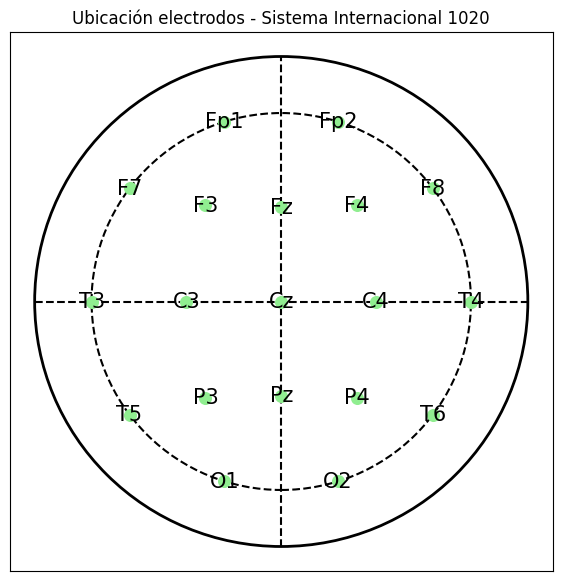

In [31]:
# Hacer una gráfica donde se vea la ubicación de los nodos (No es exacta - El montaje del sistema 1020)

fig, ax = plt.subplots(figsize=(7, 7))

ax.add_patch(Circle((0, 0), radius=1, color='black', fill=False, linestyle='--', linewidth=1.5))
ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

# Agregar segmentos
ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='black', linewidth=1.5)
ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='black', linewidth=1.5)

G = nx.Graph()
G.add_nodes_from(CHANNELS)

nx.draw_networkx(
    G,
    pos,
    node_size=70,
    with_labels=True,
    font_size=15,
    node_color='lightgreen'
)

ax.set_title('Ubicación electrodos - Sistema Internacional 1020')
plt.show()

# Ejemplo

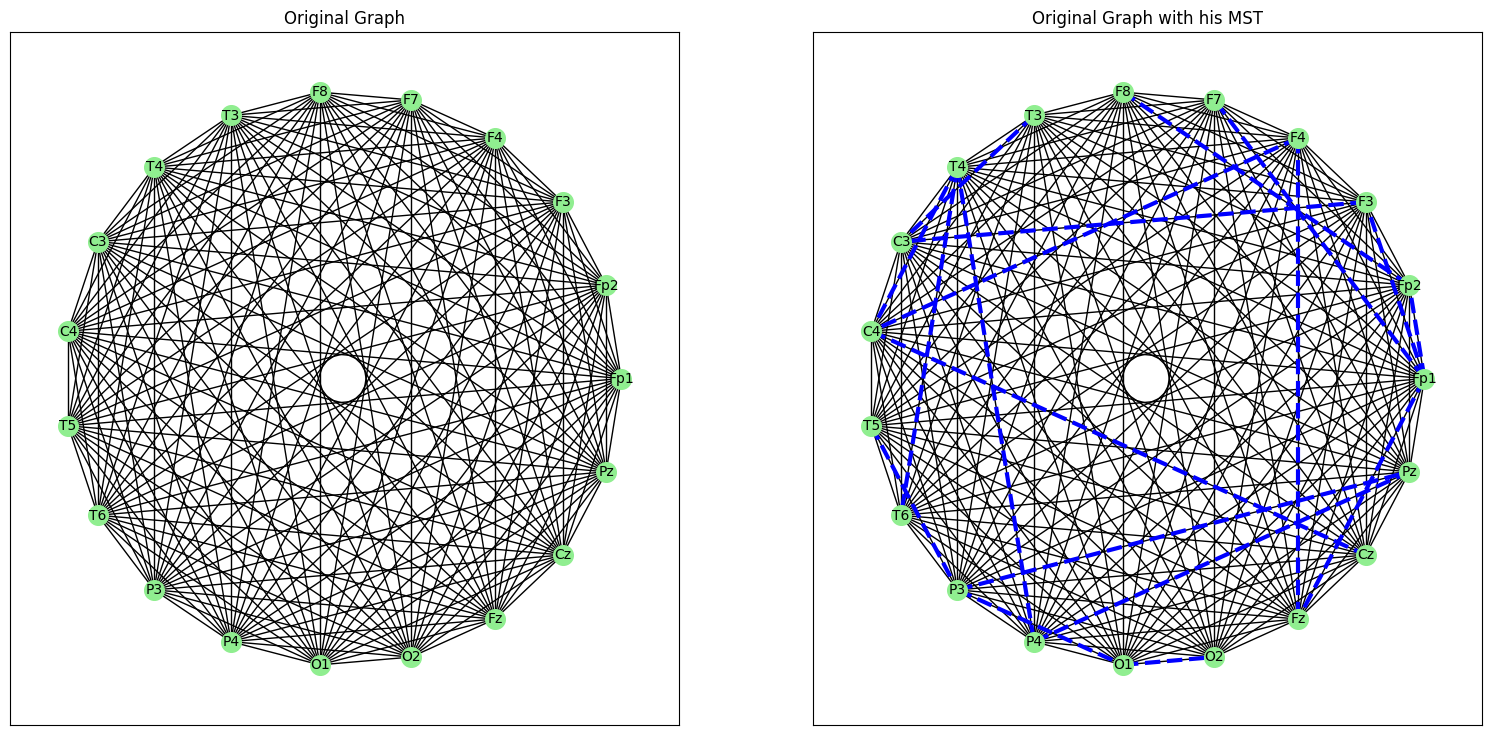

In [32]:
# mst sujeto00 antes

g0 = get_graph('Archivos\\Subject00\\csv\\Subject00_1.csv')
mst_g0 = nx.minimum_spanning_tree(g0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 9))

# Dibujar el grafo original
ax1.set_title('Original Graph')
nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax1
)

# Dibujar la MST del grafo original
ax2.set_title("Original Graph with his MST")

nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax2
)

# Dibujarle las lineas de las aristas
edges_mst = [(u, v) for u, v in mst_g0.edges]
nx.draw_networkx_edges(
    mst_g0, pos=nx.circular_layout(g0), edgelist=edges_mst,
    edge_color="blue", style="dashed", width=3,
    ax=ax2
)

plt.show()

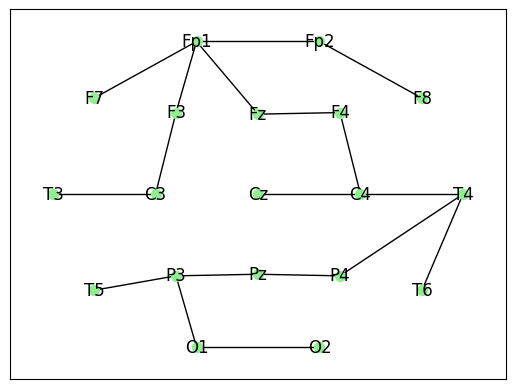

In [33]:
mst_g1 = get_mst('Archivos\\Subject00\\csv\\Subject00_1.csv')
nx.draw_networkx(
    mst_g1,
    pos,
    node_size=50,
    node_color='lightgreen'
)

In [34]:
density = nx.density(mst_g0)
ave_clustering = nx.average_clustering(mst_g0)

print(f'Density: {density}')
print(f'Average clustering: {ave_clustering}\n')

degree_centrality = nx.degree_centrality(mst_g0)
print('Degree centrality:')
pprint(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

betweenness_centrality = nx.betweenness_centrality(mst_g0)
print('\nBetweenness centrality')
pprint(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

closeness_centrality = nx.closeness_centrality(mst_g0)
print('\nClossenes centrality')
pprint(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
print('\nPagerank')
pprint(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Density: 0.10526315789473684
Average clustering: 0.0

Degree centrality:
[('Fp1', 0.2222222222222222),
 ('T4', 0.16666666666666666),
 ('C4', 0.16666666666666666),
 ('P3', 0.16666666666666666),
 ('Fp2', 0.1111111111111111)]

Betweenness centrality
[('C4', 0.5816993464052288),
 ('Fp1', 0.542483660130719),
 ('T4', 0.542483660130719),
 ('F4', 0.5228758169934641),
 ('Fz', 0.5032679738562091)]

Clossenes centrality
[('C4', 0.2857142857142857),
 ('F4', 0.28125),
 ('T4', 0.2727272727272727),
 ('Fz', 0.26865671641791045),
 ('Fp1', 0.25)]

Pagerank
[('Fp1', 0.09149770068455913),
 ('C4', 0.08444884743931488),
 ('P3', 0.08163972880765996),
 ('T4', 0.07444660175713706),
 ('C3', 0.06886785408619195)]


In [35]:
# Datos para sacar los diagrama de barras para cada medida de centralidad
df_centrality = pd.DataFrame({
    'nodes': CHANNELS,
    'degree': degree_centrality.values(),
    'betweenness': betweenness_centrality.values(),
    'closeness': closeness_centrality.values(),
    'pagerank': pagerank.values()
})

df_centrality

nodes    degree  betweenness  closeness  pagerank
0    Fp1  0.222222     0.542484   0.250000  0.091498
1    Fp2  0.111111     0.111111   0.206897  0.052705
2     F3  0.111111     0.209150   0.211765  0.048032
3     F4  0.111111     0.522876   0.281250  0.047958
4     F7  0.055556     0.000000   0.202247  0.039825
5     F8  0.055556     0.000000   0.173077  0.037318
6     T3  0.055556     0.000000   0.153846  0.040268
7     T4  0.166667     0.542484   0.272727  0.074447
8     C3  0.111111     0.111111   0.180000  0.068868
9     C4  0.166667     0.581699   0.285714  0.084449
10    T5  0.055556     0.000000   0.163636  0.035153
11    T6  0.055556     0.000000   0.216867  0.028639
12    P3  0.166667     0.307190   0.193548  0.081640
13    P4  0.111111     0.424837   0.246575  0.050938
14    O1  0.111111     0.111111   0.166667  0.062500
15    O2  0.055556     0.000000   0.144000  0.035970
16    Fz  0.111111     0.503268   0.268657  0.039673
17    Cz  0.055556     0.000000   0.225000  0.033773
18    Pz  0.111111     0.366013   0.219512  0.046348

# Medidas de centralidad para todos los participantes - Antes y durante

In [37]:
# Guarda las medidas de centralidad de los sujetos (antes y despues) en archivos

df_before = pd.DataFrame()
df_during = pd.DataFrame()

for i in range(0, 35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    df_temp1 = pd.DataFrame({'subject': [subject]*19})
    df_temp1 = pd.concat([df_temp1, centrality(csv_path1)], axis=1)
    df_temp1['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_before = pd.concat([df_before, df_temp1], ignore_index=True)

    df_temp2 = pd.DataFrame({'subject': [subject]*19})
    df_temp2 = pd.concat([df_temp2, centrality(csv_path2)], axis=1)
    df_temp2['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_during = pd.concat([df_during, df_temp2], ignore_index=True)

df_before.to_csv('Archivos\centrality_before.csv', sep=';', index=False)
df_during.to_csv('Archivos\centrality_during.csv', sep=';', index=False)

In [38]:
df_before = pd.read_csv('Archivos\centrality_before.csv', delimiter=';')
df_before['state'] = 'before'

df_during = pd.read_csv('Archivos\centrality_during.csv', delimiter=';')
df_during['state'] = 'during'

df_result = pd.concat([df_before, df_during], ignore_index=True)
df_result

subject nodes    degree  betweenness  closeness  pagerank  \
0     Subject00   Fp1  0.222222     0.542484   0.250000  0.091498   
1     Subject00   Fp2  0.111111     0.111111   0.206897  0.052705   
2     Subject00    F3  0.111111     0.209150   0.211765  0.048032   
3     Subject00    F4  0.111111     0.522876   0.281250  0.047958   
4     Subject00    F7  0.055556     0.000000   0.202247  0.039825   
...         ...   ...       ...          ...        ...       ...   
1363  Subject35    O1  0.111111     0.366013   0.240000  0.047845   
1364  Subject35    O2  0.111111     0.294118   0.209302  0.046606   
1365  Subject35    Fz  0.222222     0.398693   0.240000  0.094454   
1366  Subject35    Cz  0.111111     0.529412   0.300000  0.040158   
1367  Subject35    Pz  0.055556     0.000000   0.155172  0.027799   

     count_quality   state  
0                B  before  
1                B  before  
2                B  before  
3                B  before  
4                B  before  
...            ...     ...  
1363             G  during  
1364             G  during  
1365             G  during  
1366             G  during  
1367             G  during  

[1368 rows x 8 columns]

In [39]:
# Función para graficar todas las métricas dado un sensor

def boxplots(sensor: str) -> None:
    df_sensor = df_result[df_result['nodes'] == sensor]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

    fig.suptitle(f'{sensor} centrality measures')

    ax1.set_title(f'{sensor} boxplot for degree centrality')
    sns.boxplot(
        df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
    )

    ax2.set_title(f'{sensor} boxplot for betweenness centrality')
    sns.boxplot(
        df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
    )

    ax3.set_title(f'{sensor} boxplot for closeness centrality')
    sns.boxplot(
        df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
    )

    ax4.set_title(f'{sensor} boxplot for pagerank')
    sns.boxplot(
        df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
    )

    plt.tight_layout()
    plt.show()

## Prefrontal (Fp)

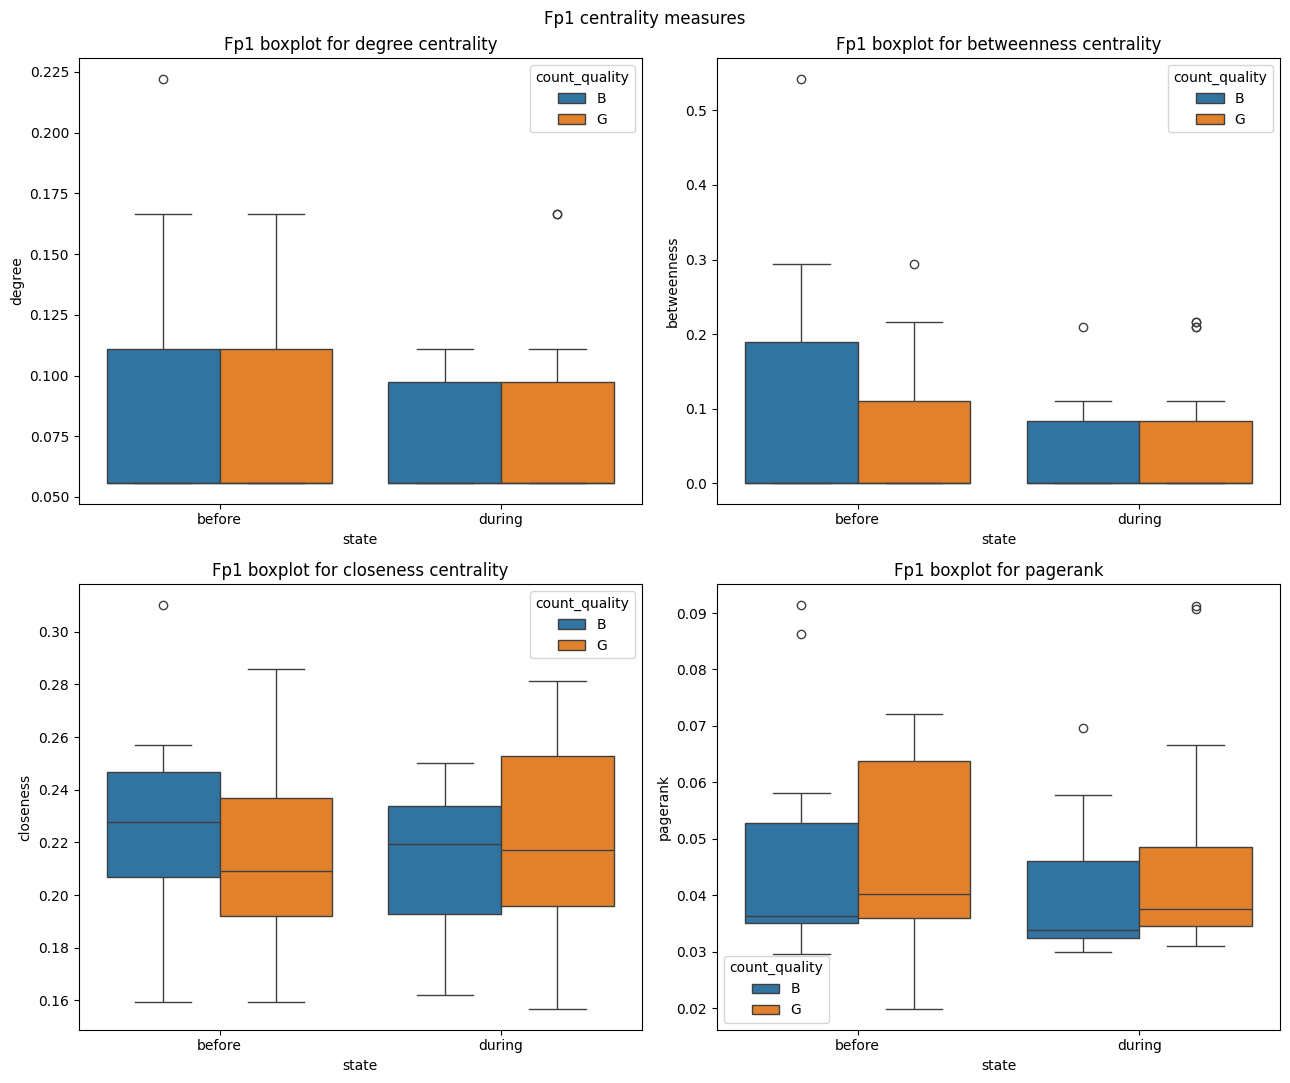

In [40]:
# Todas las gráficas de Fp1 para cada métrica diferente
boxplots('Fp1')

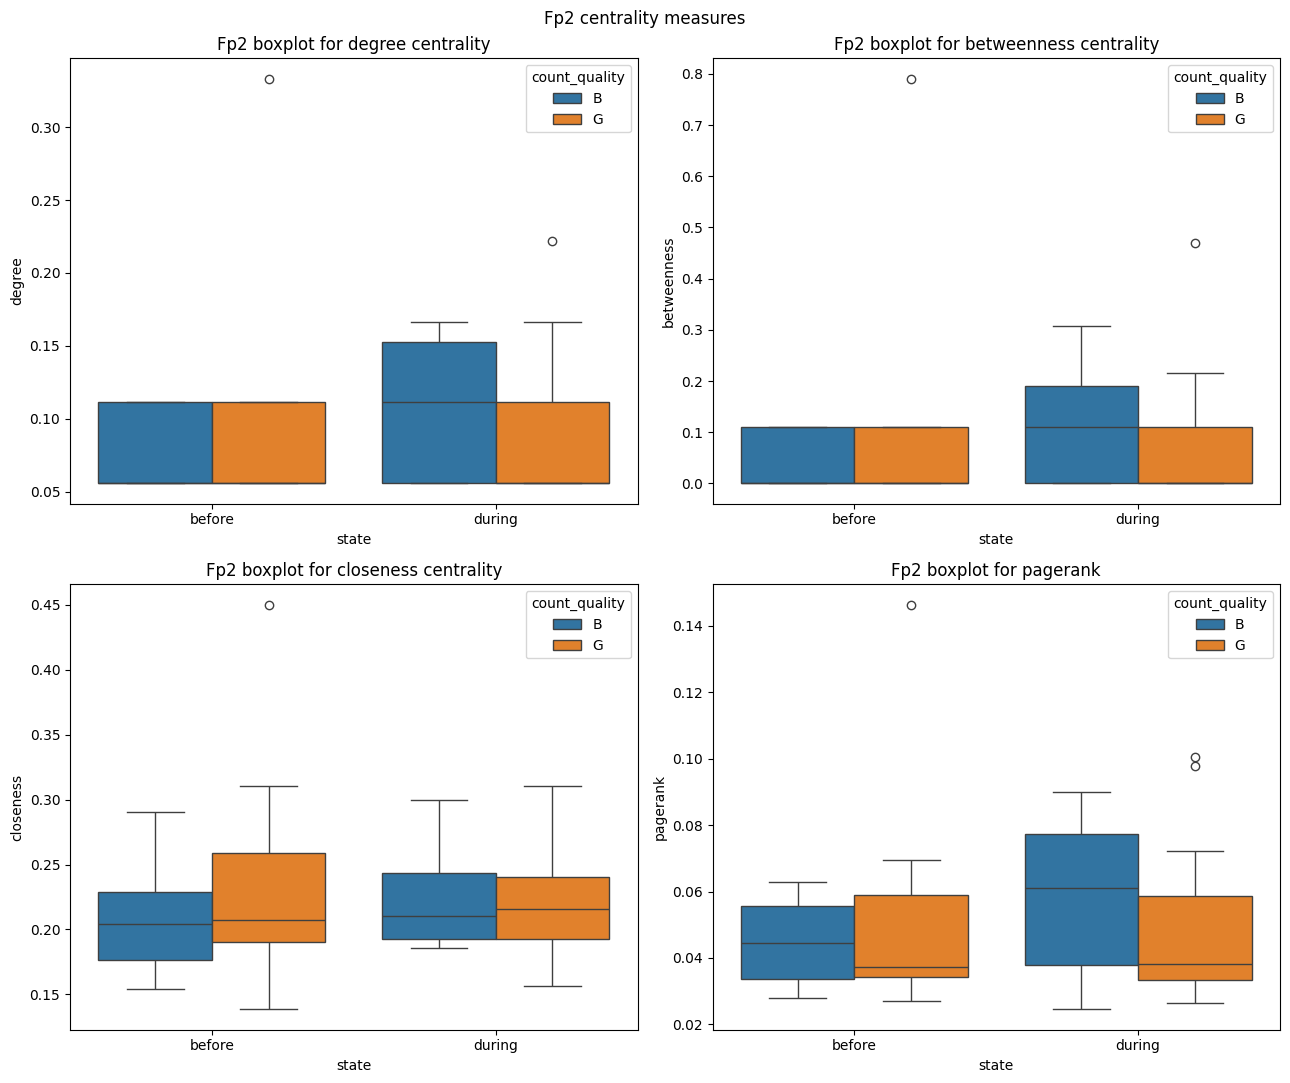

In [41]:
boxplots('Fp2')

## Frontal (F)

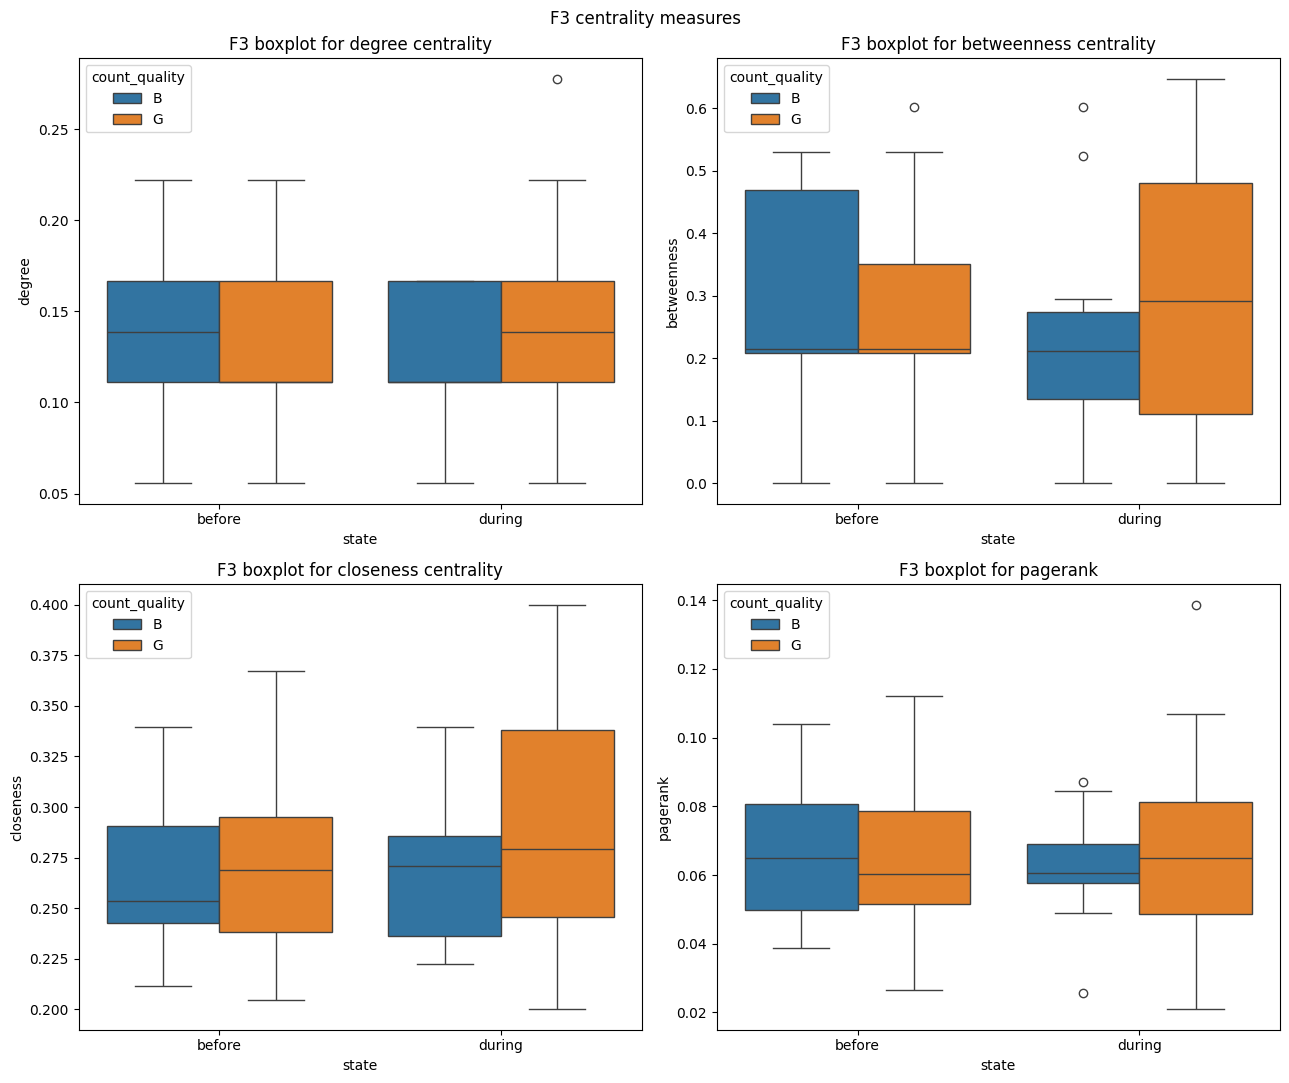

In [42]:
boxplots('F3')

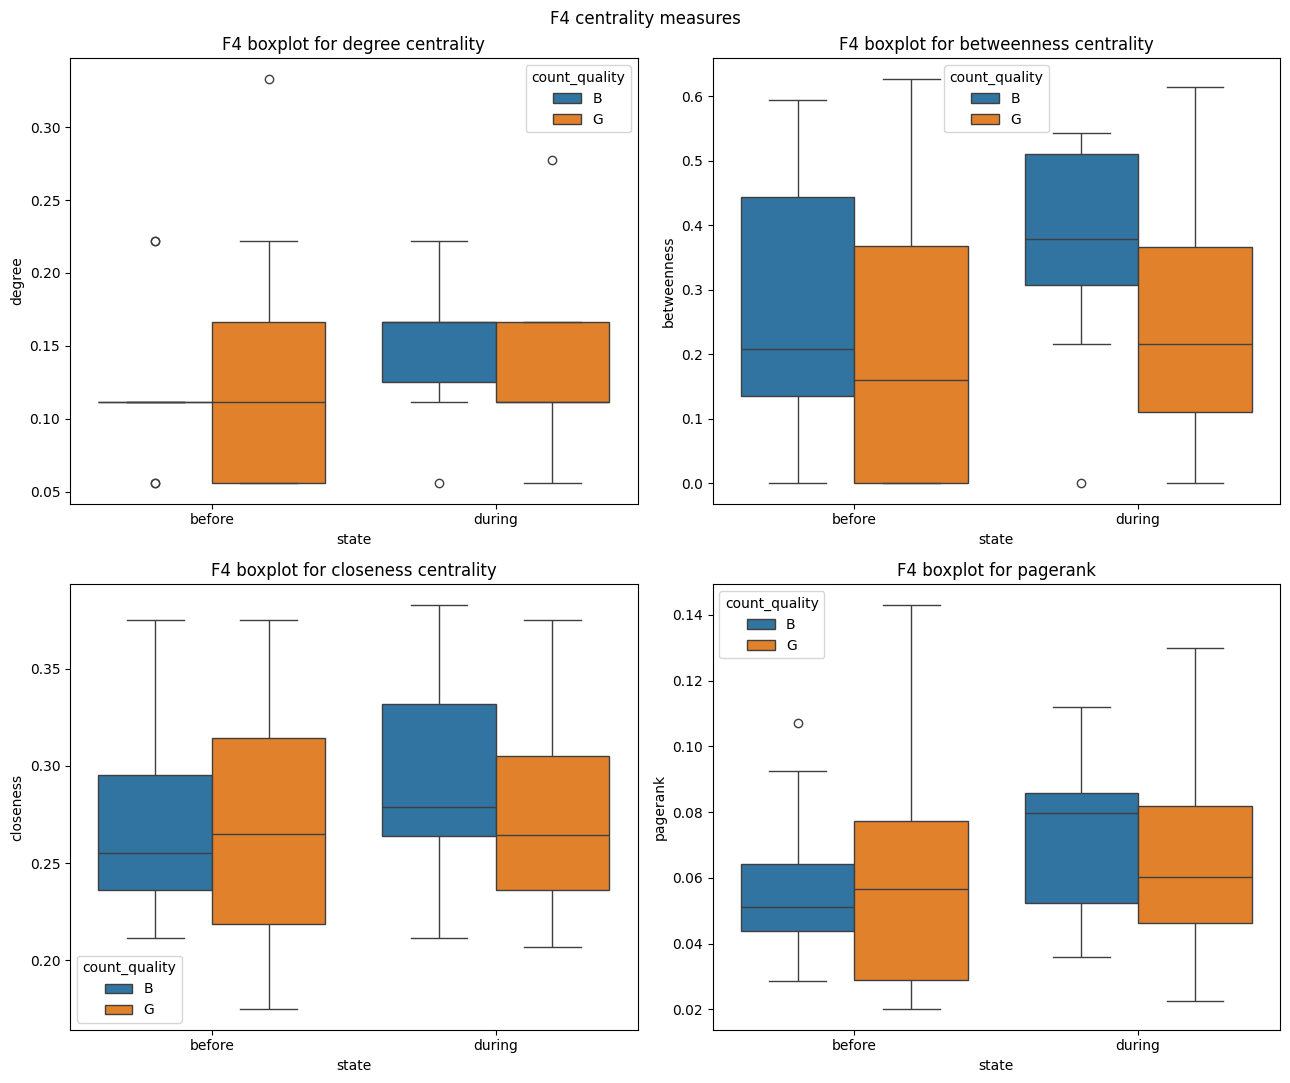

In [43]:
boxplots('F4')

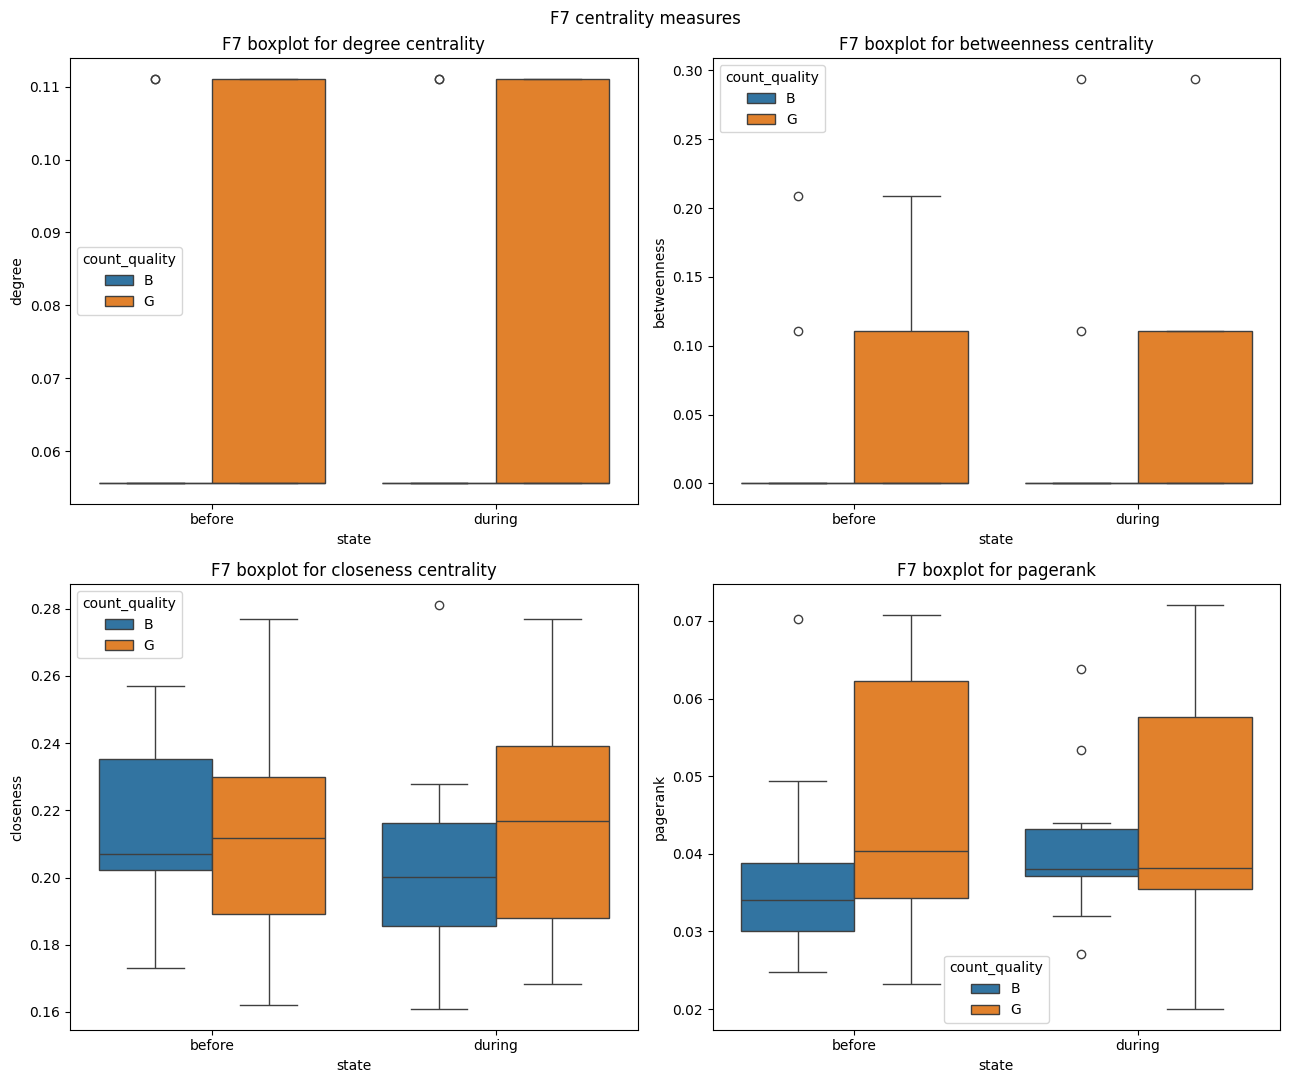

In [44]:
boxplots('F7')

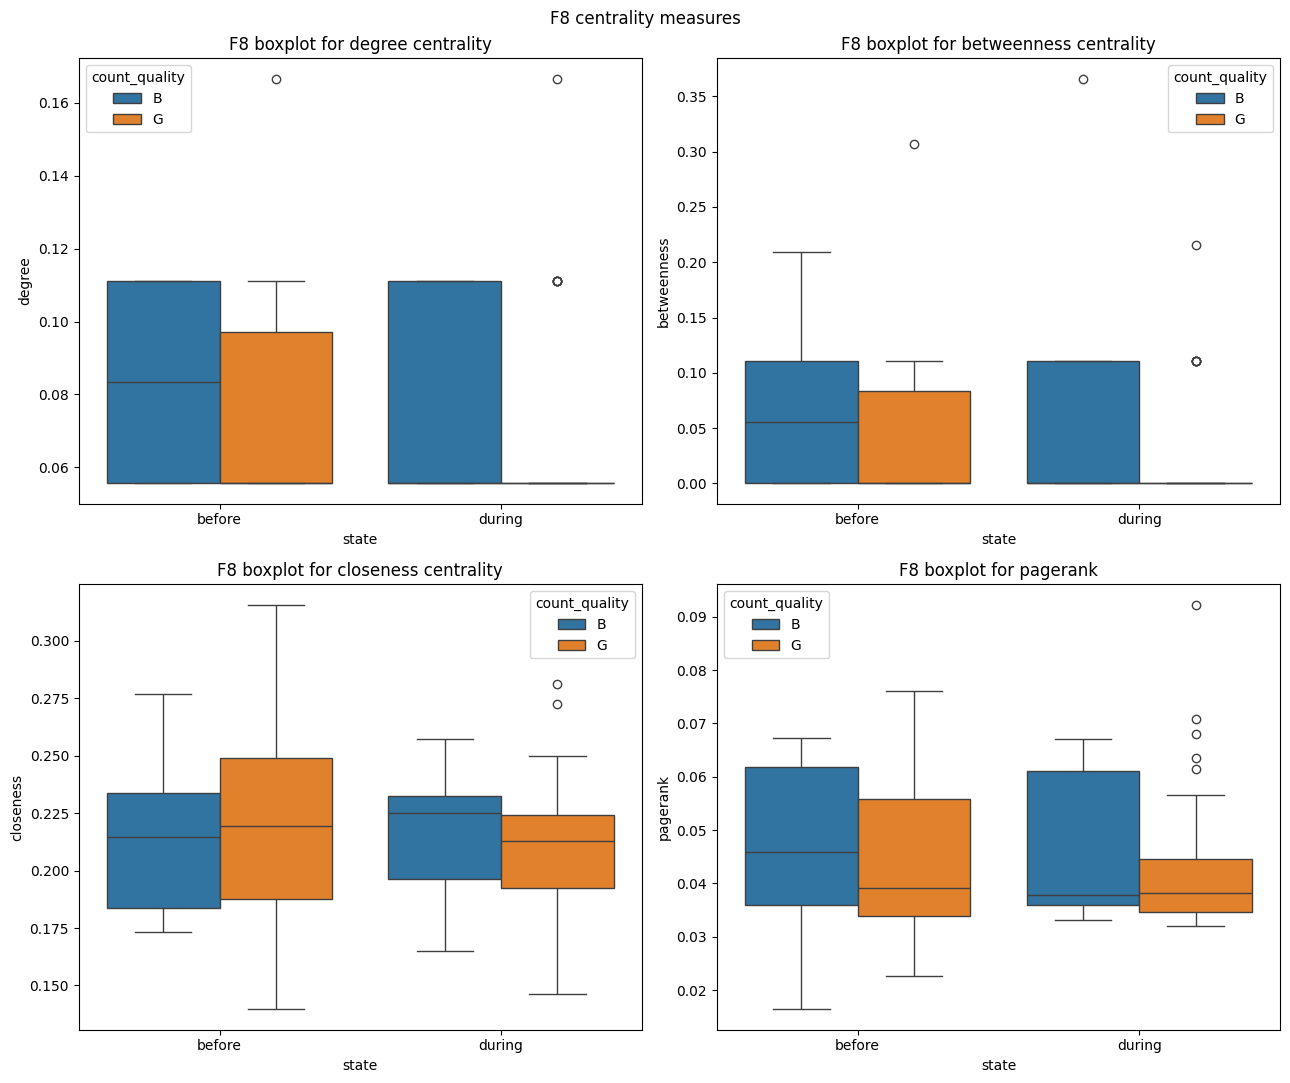

In [45]:
boxplots('F8')

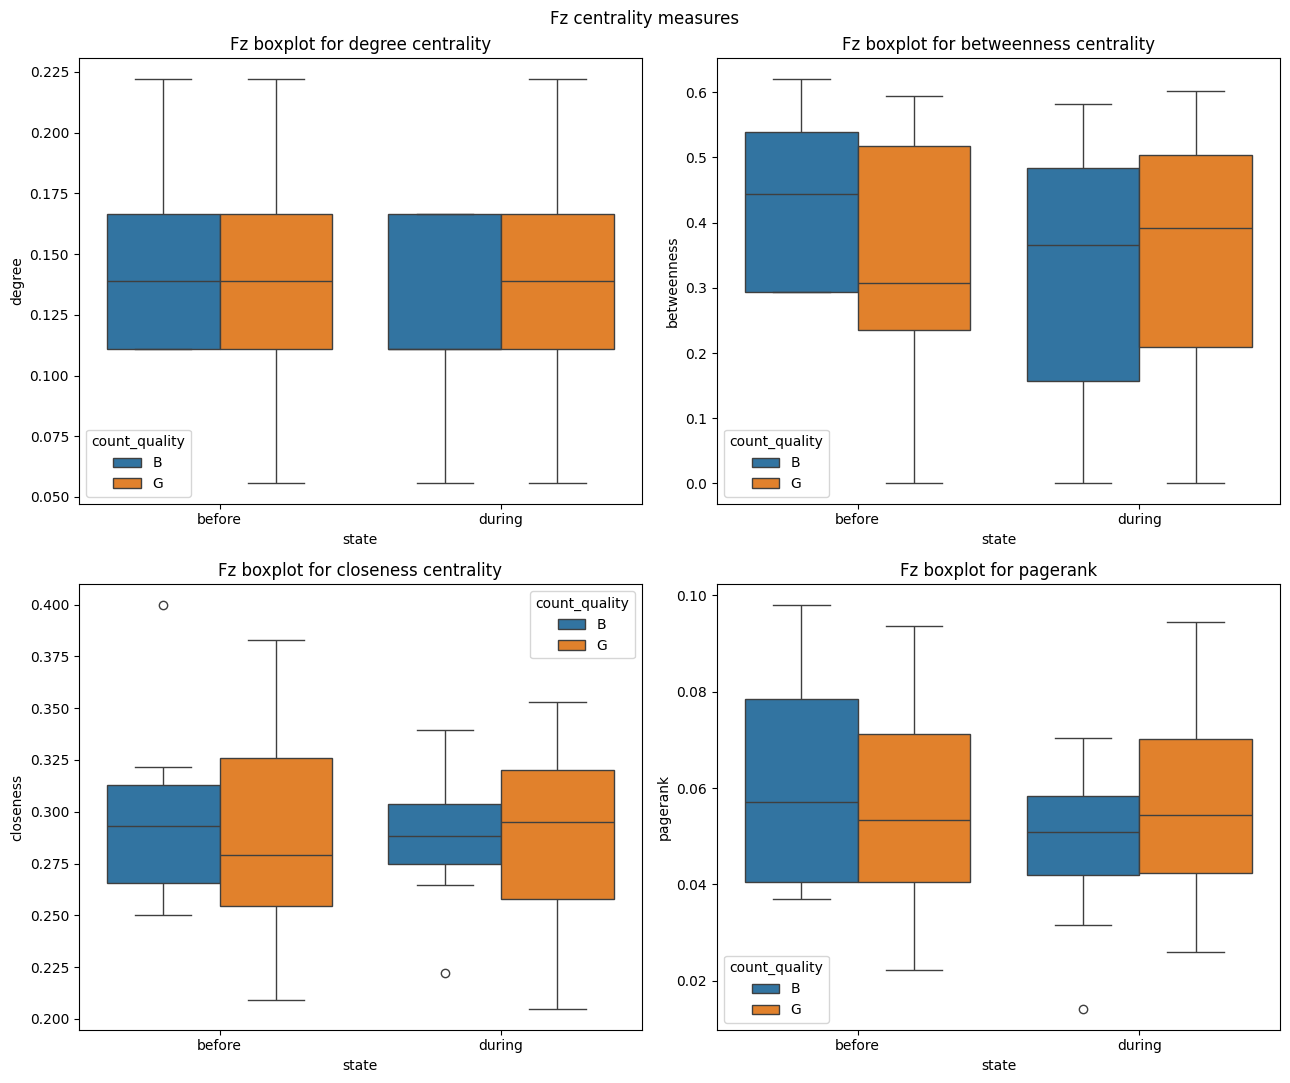

In [46]:
boxplots('Fz')

## Temporal (T)

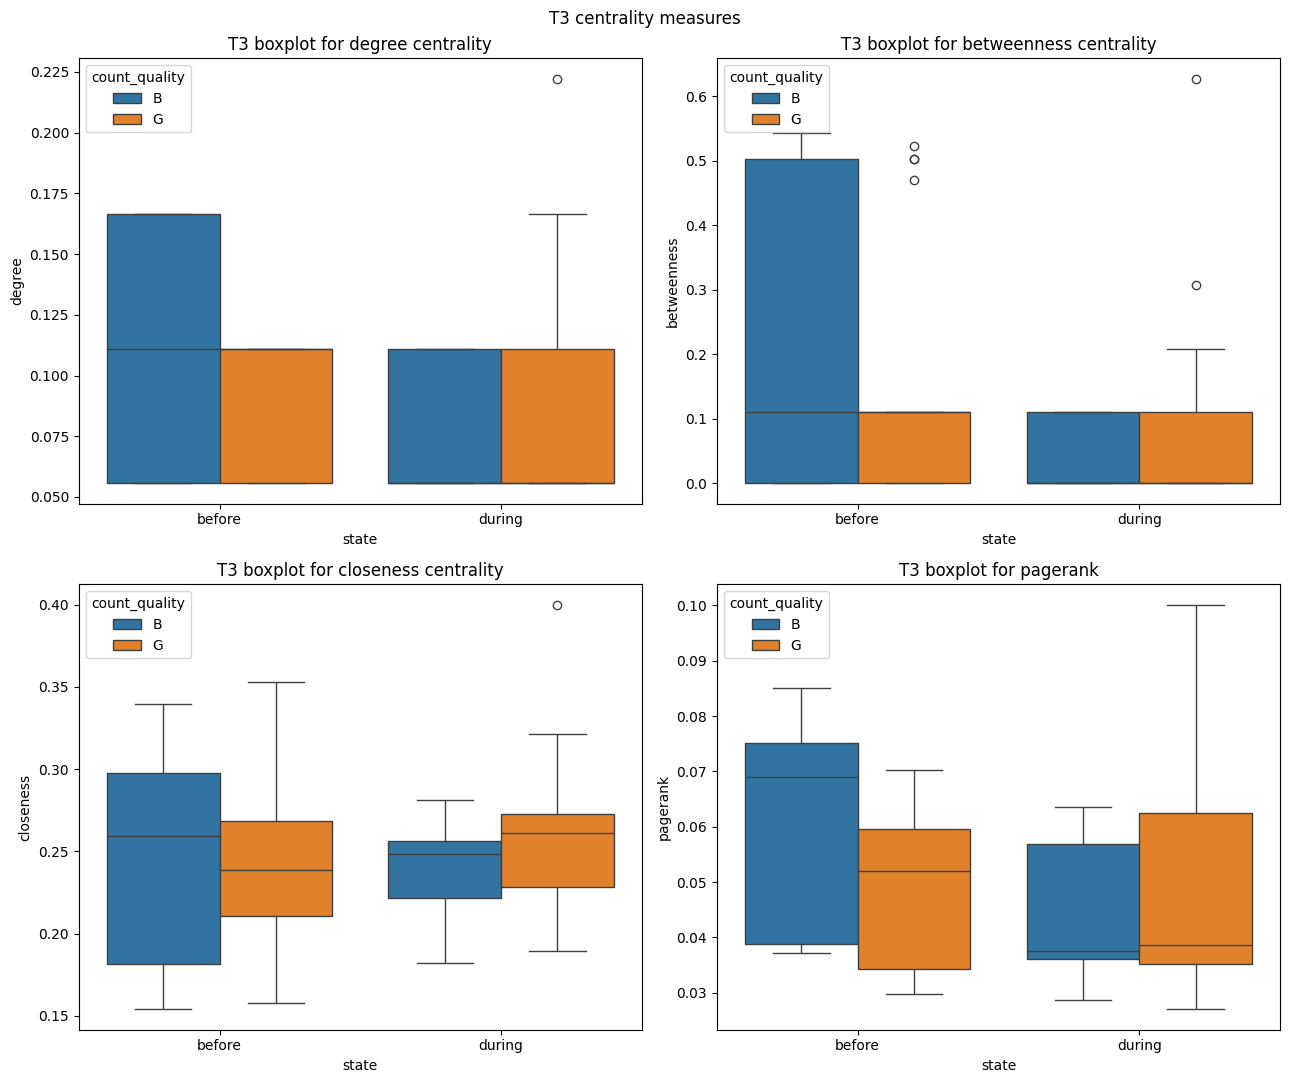

In [47]:
boxplots('T3')

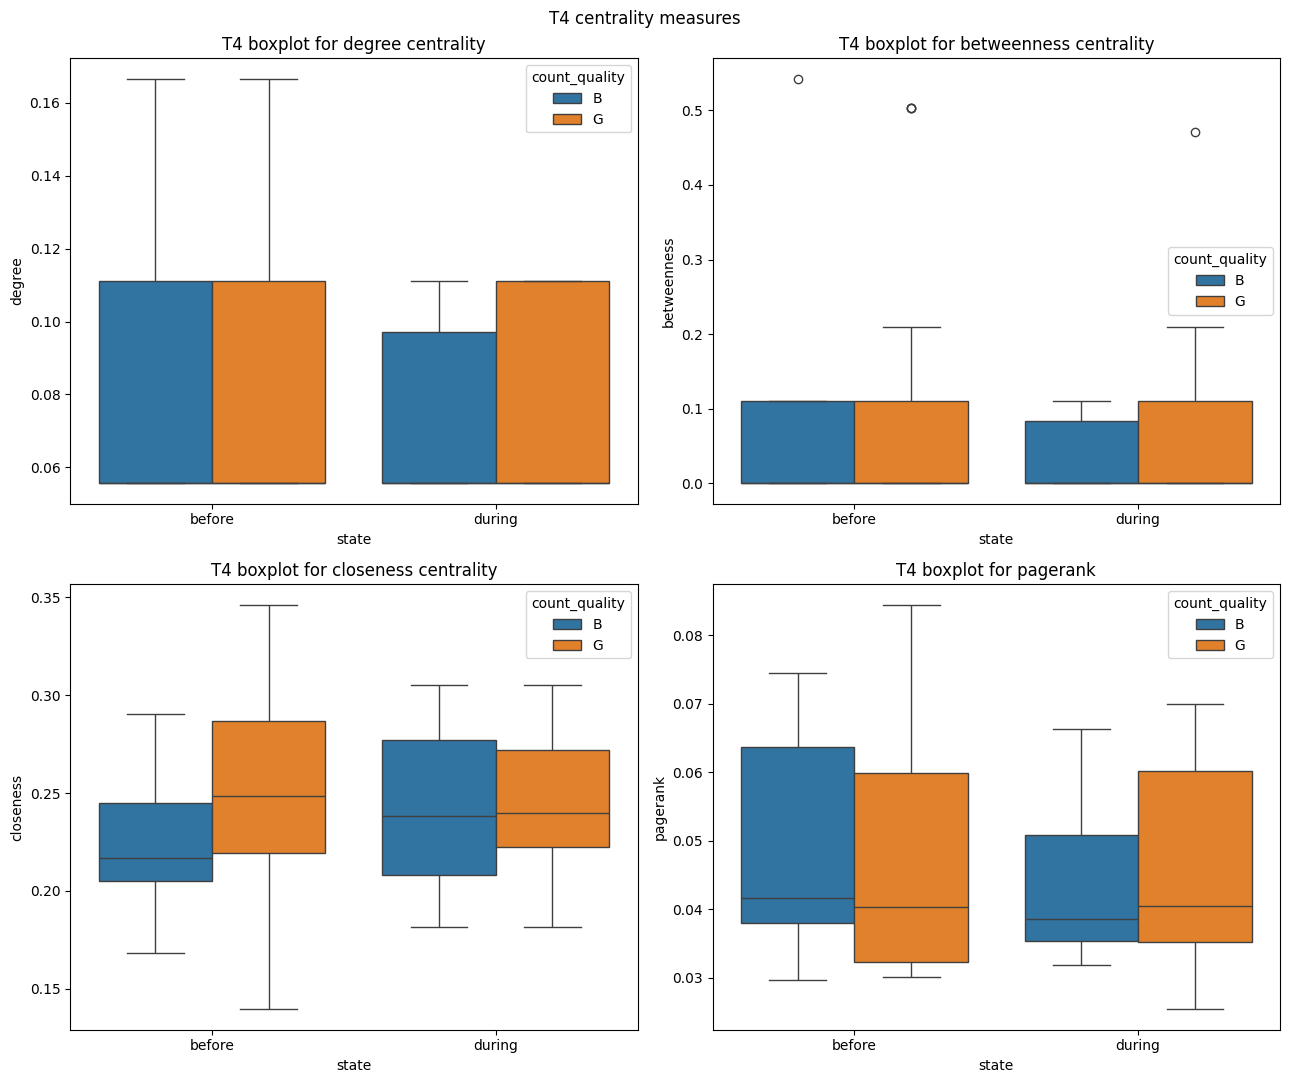

In [48]:
boxplots('T4')

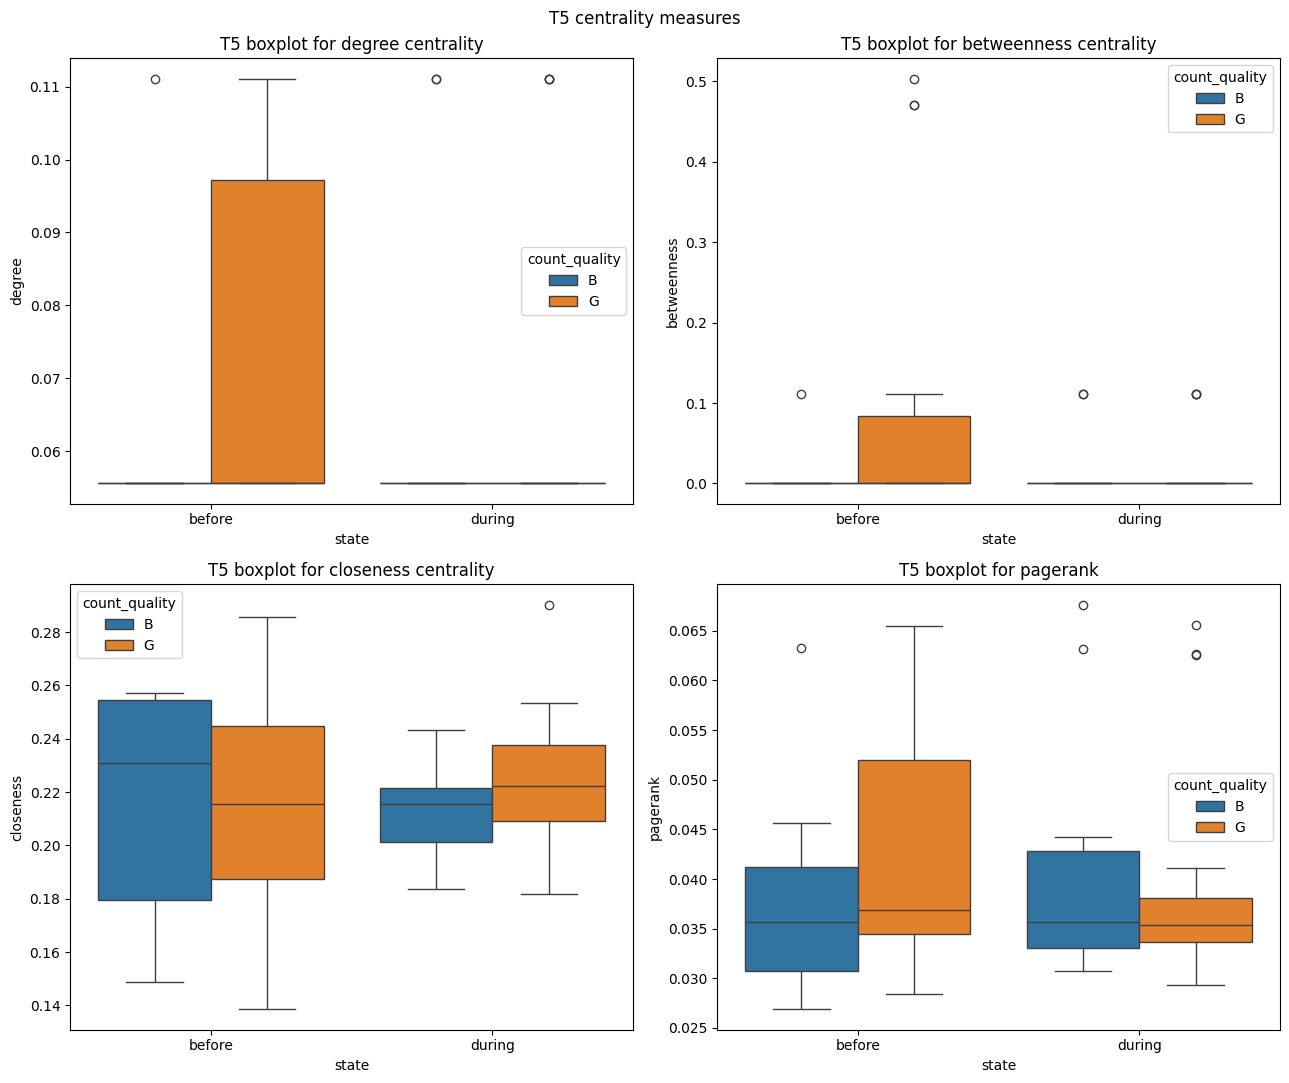

In [49]:
boxplots('T5')

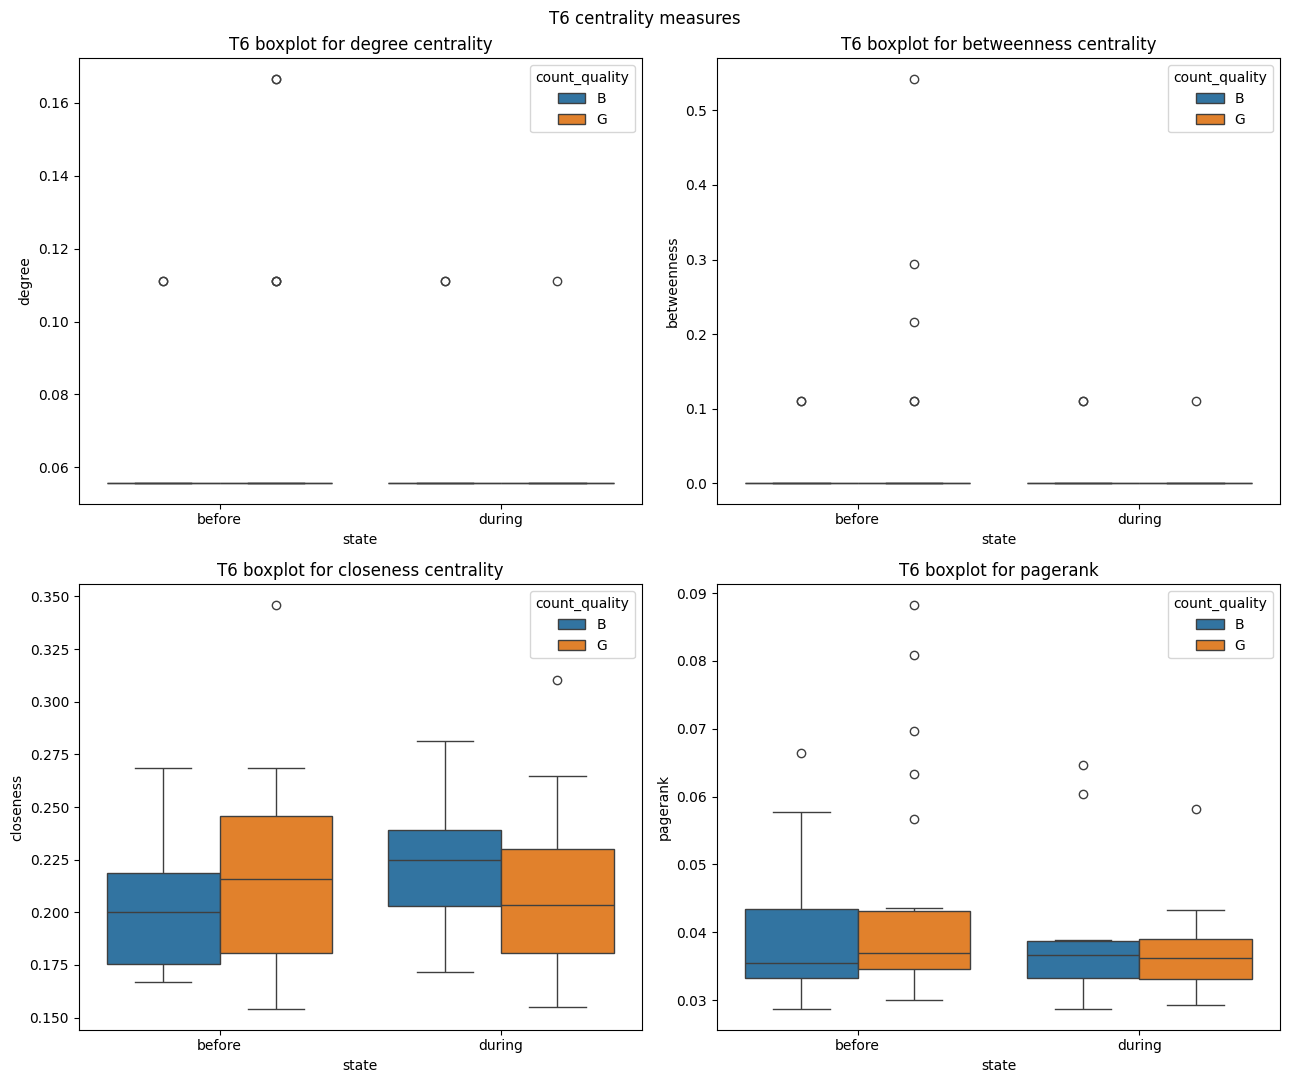

In [50]:
boxplots('T6')

## Central (C)

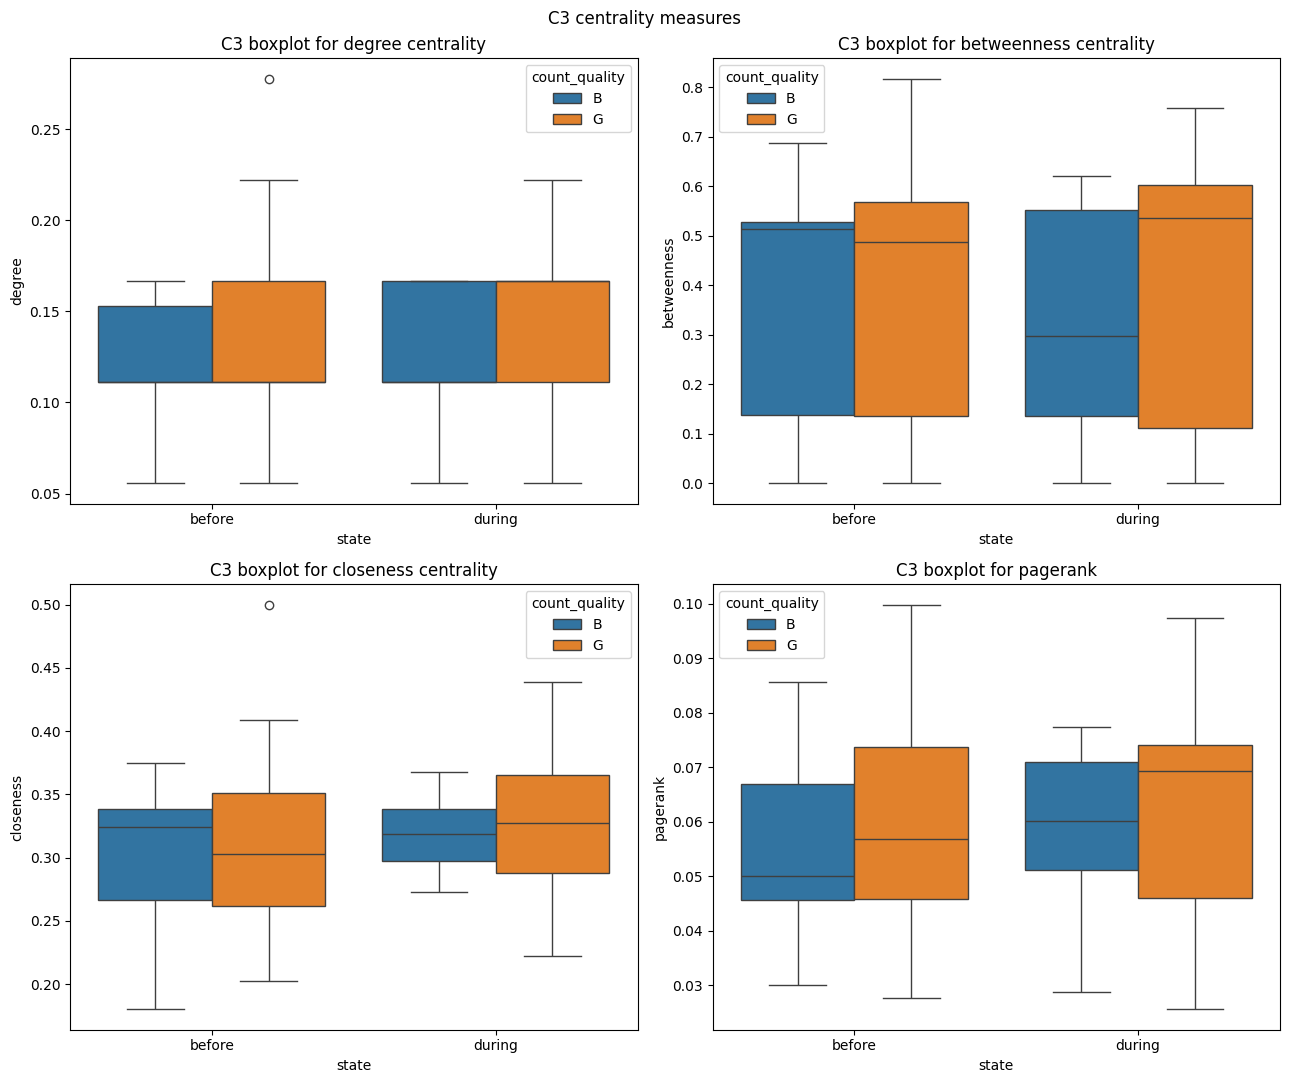

In [51]:
boxplots('C3')

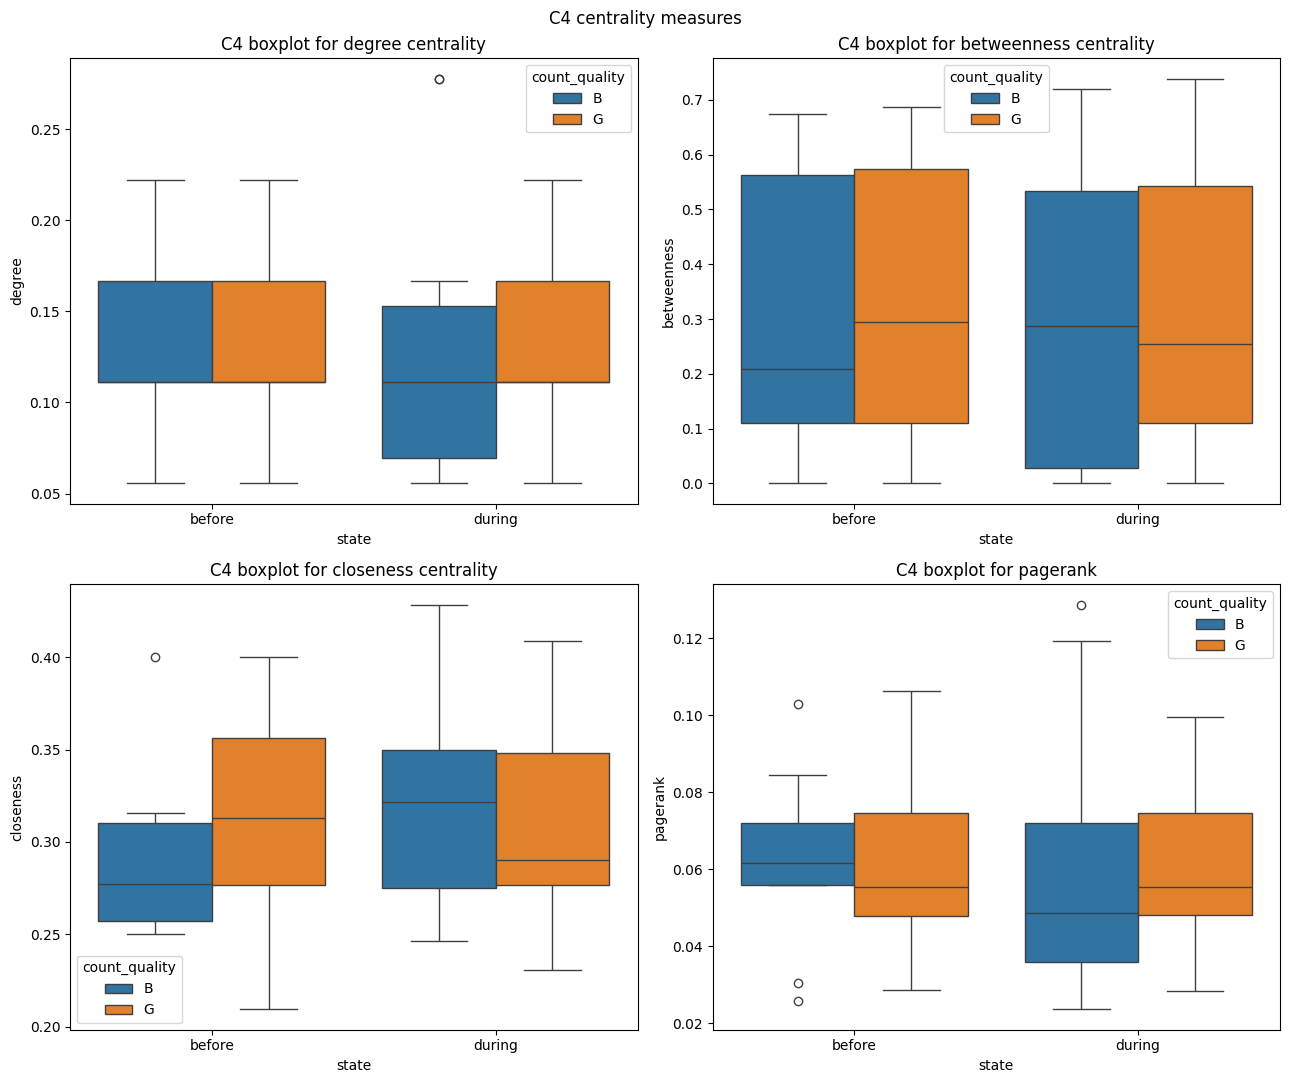

In [52]:
boxplots('C4')

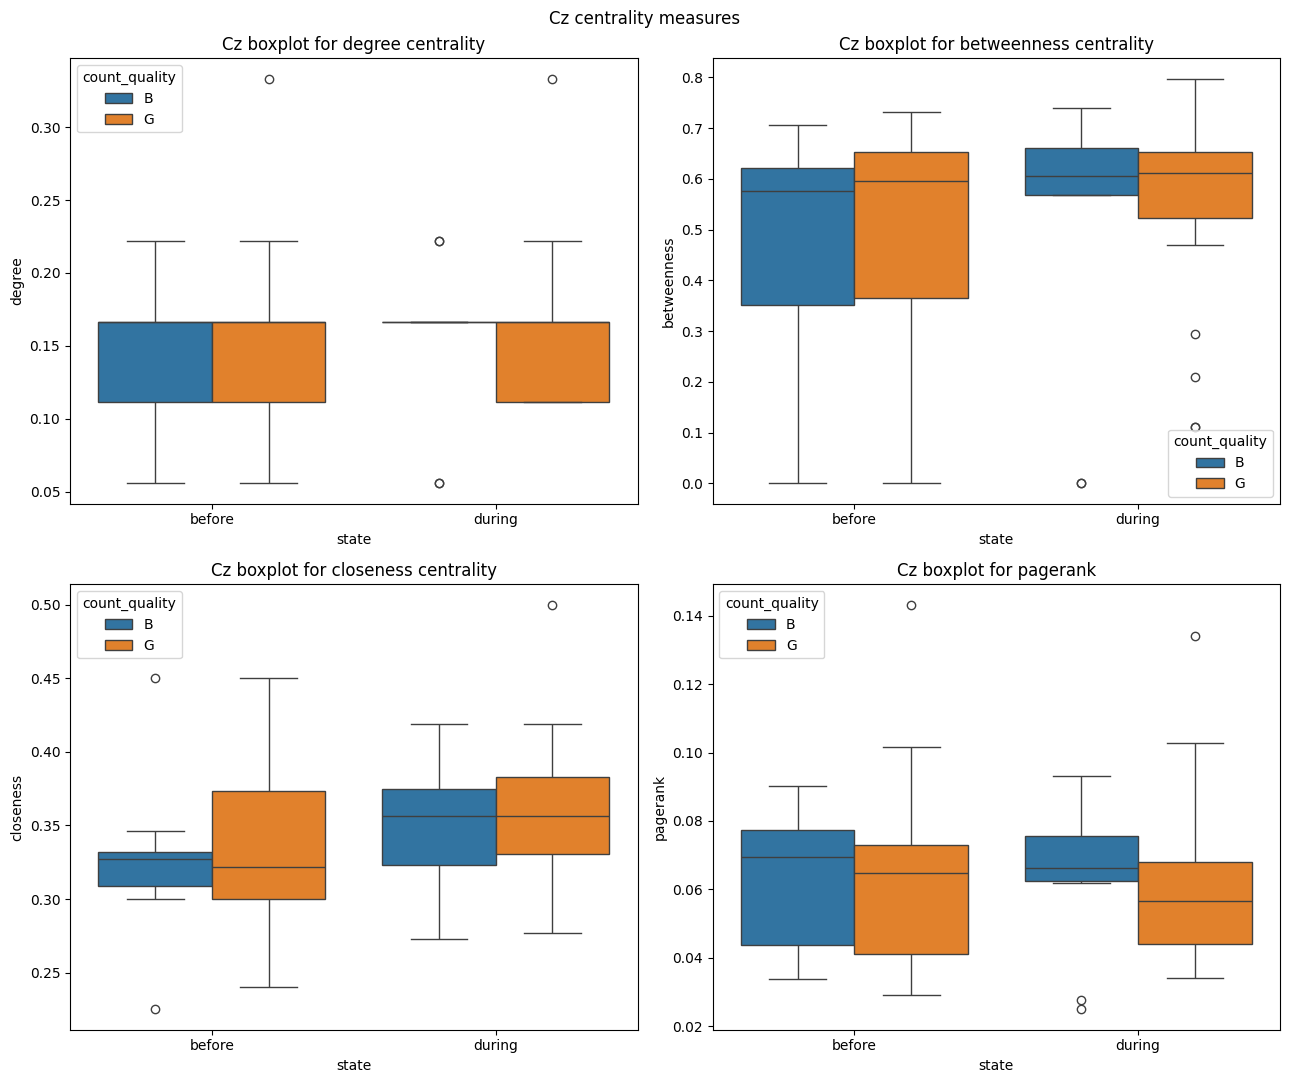

In [53]:
boxplots('Cz')

## Parietal (P)

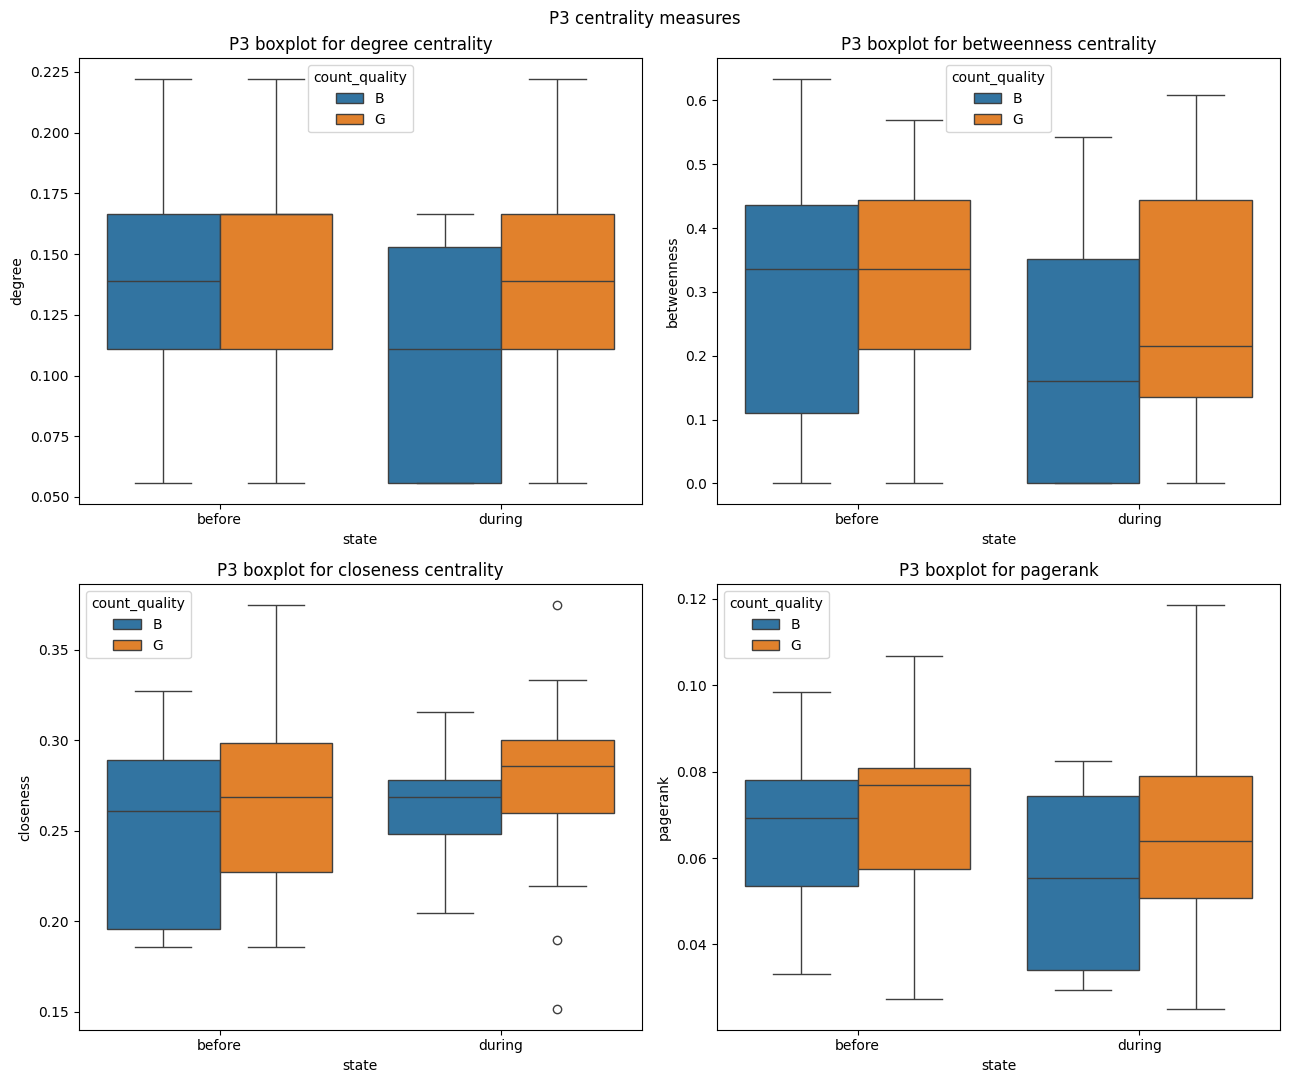

In [54]:
boxplots('P3')

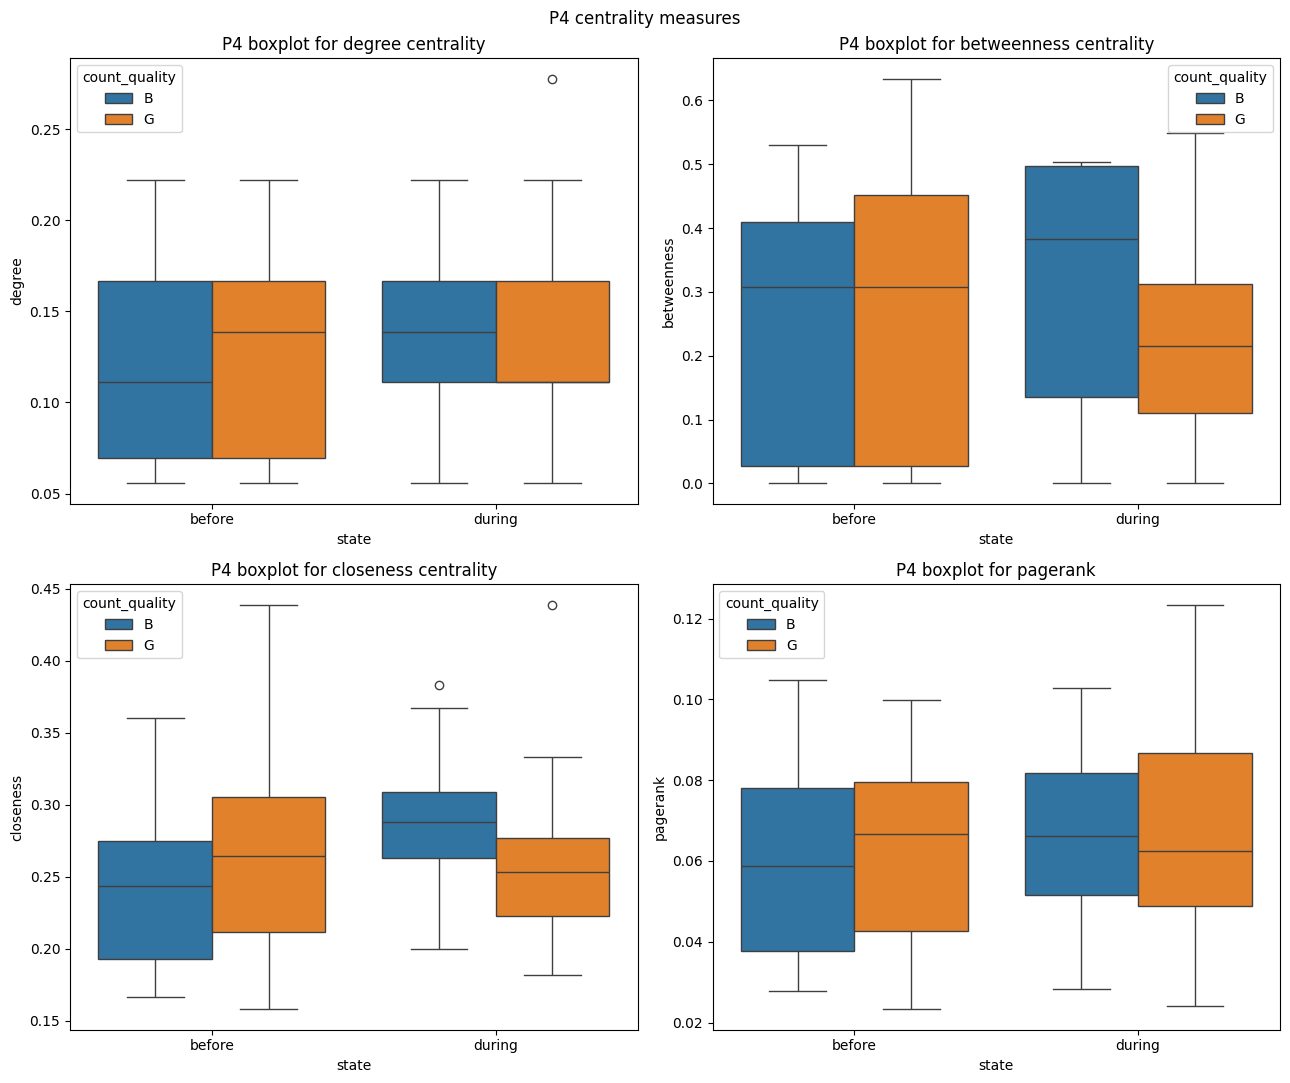

In [55]:
boxplots('P4')

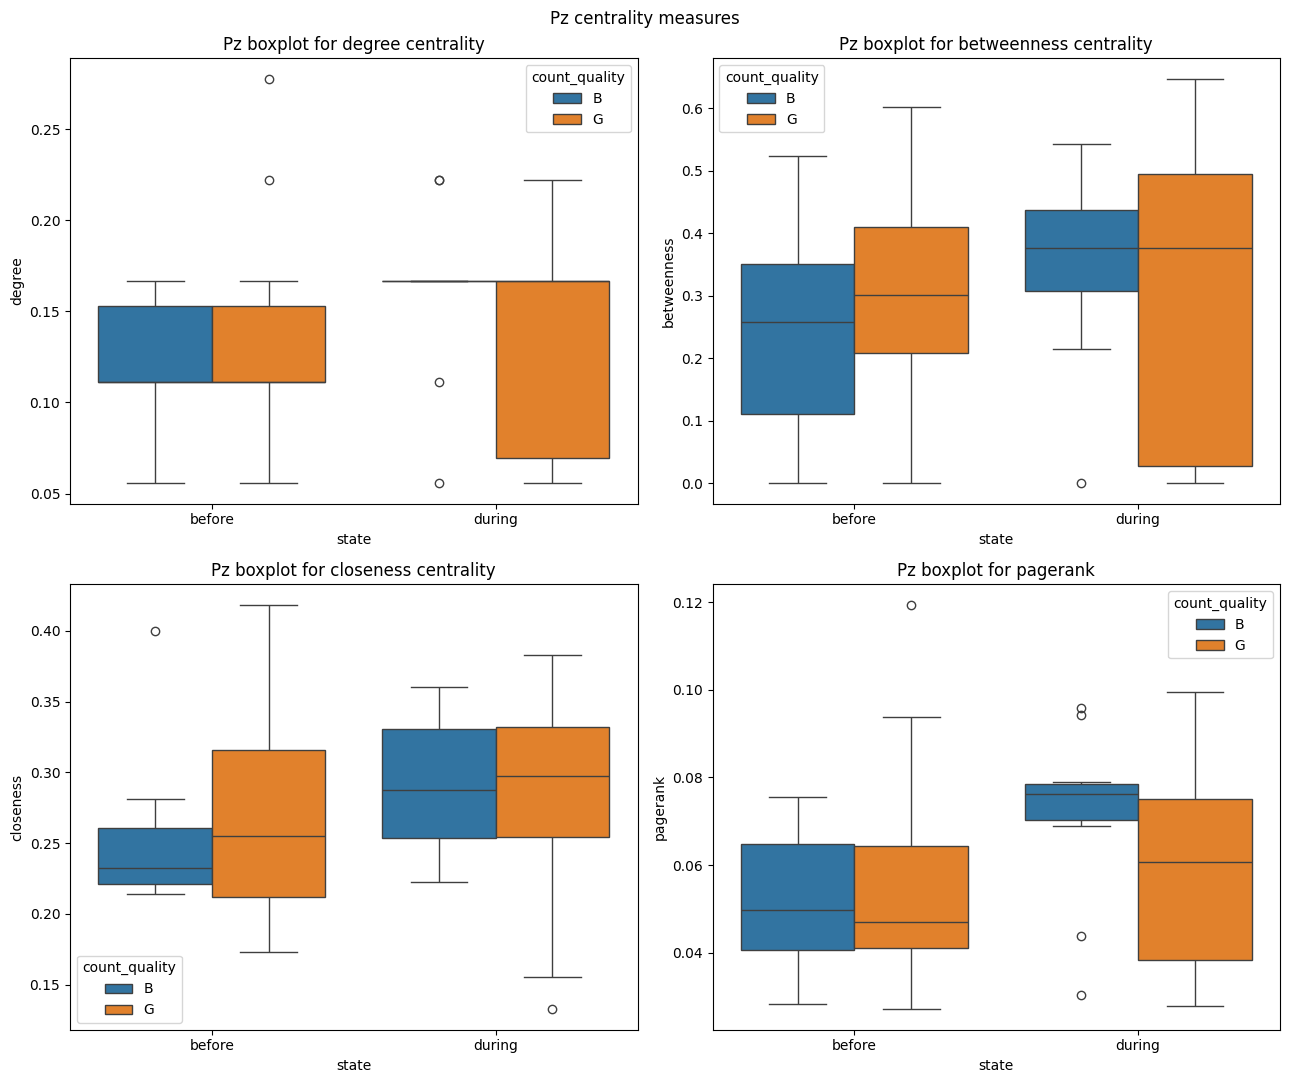

In [56]:
boxplots('Pz')

## Occipital (O)

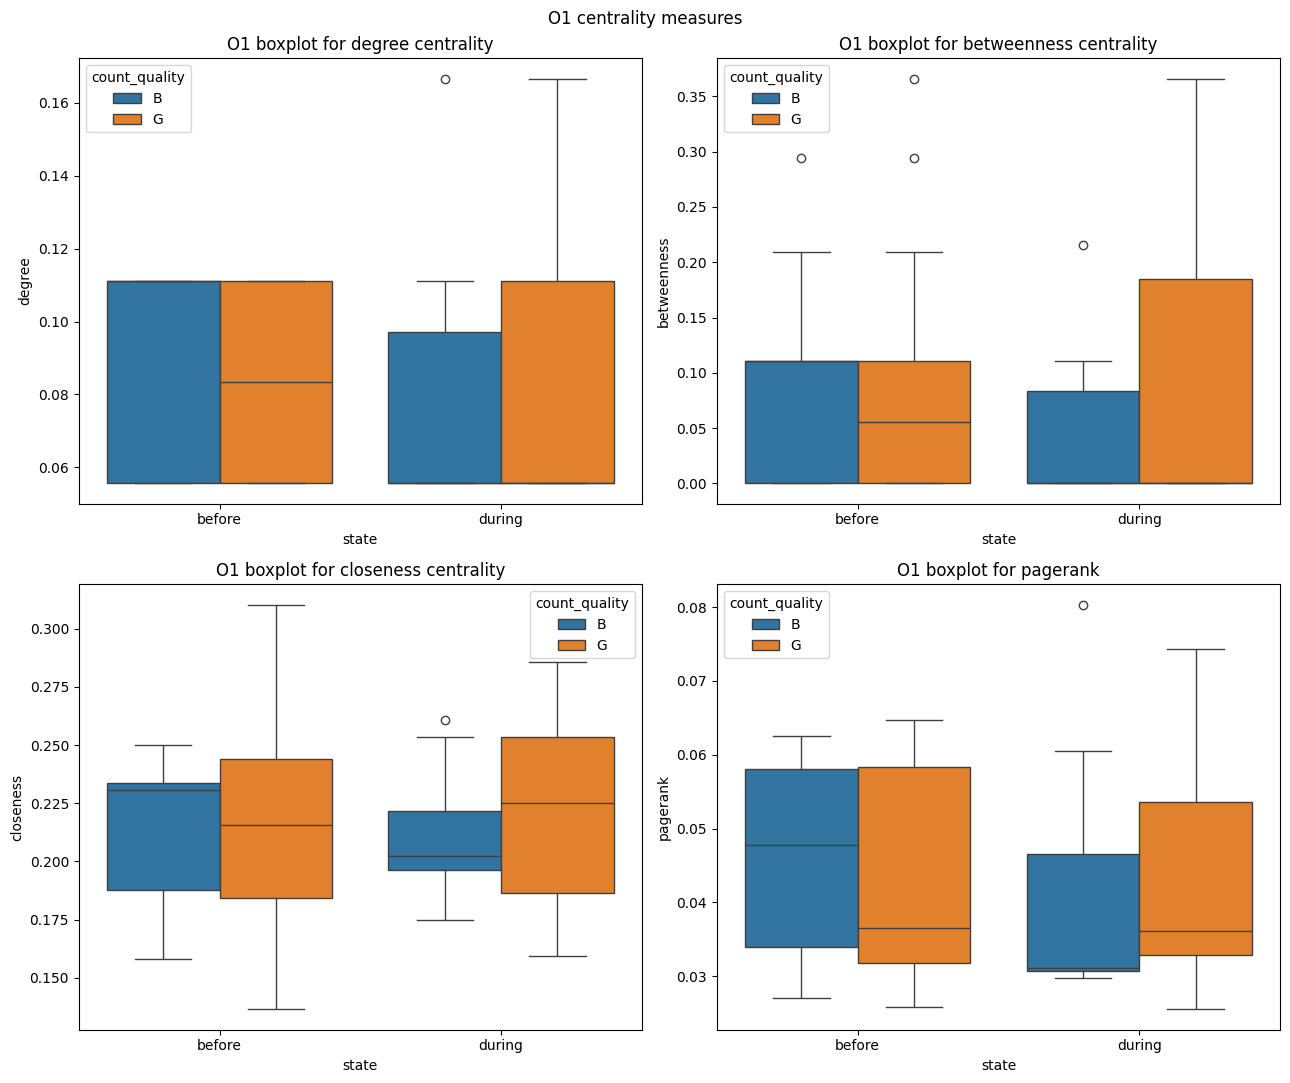

In [57]:
boxplots('O1')

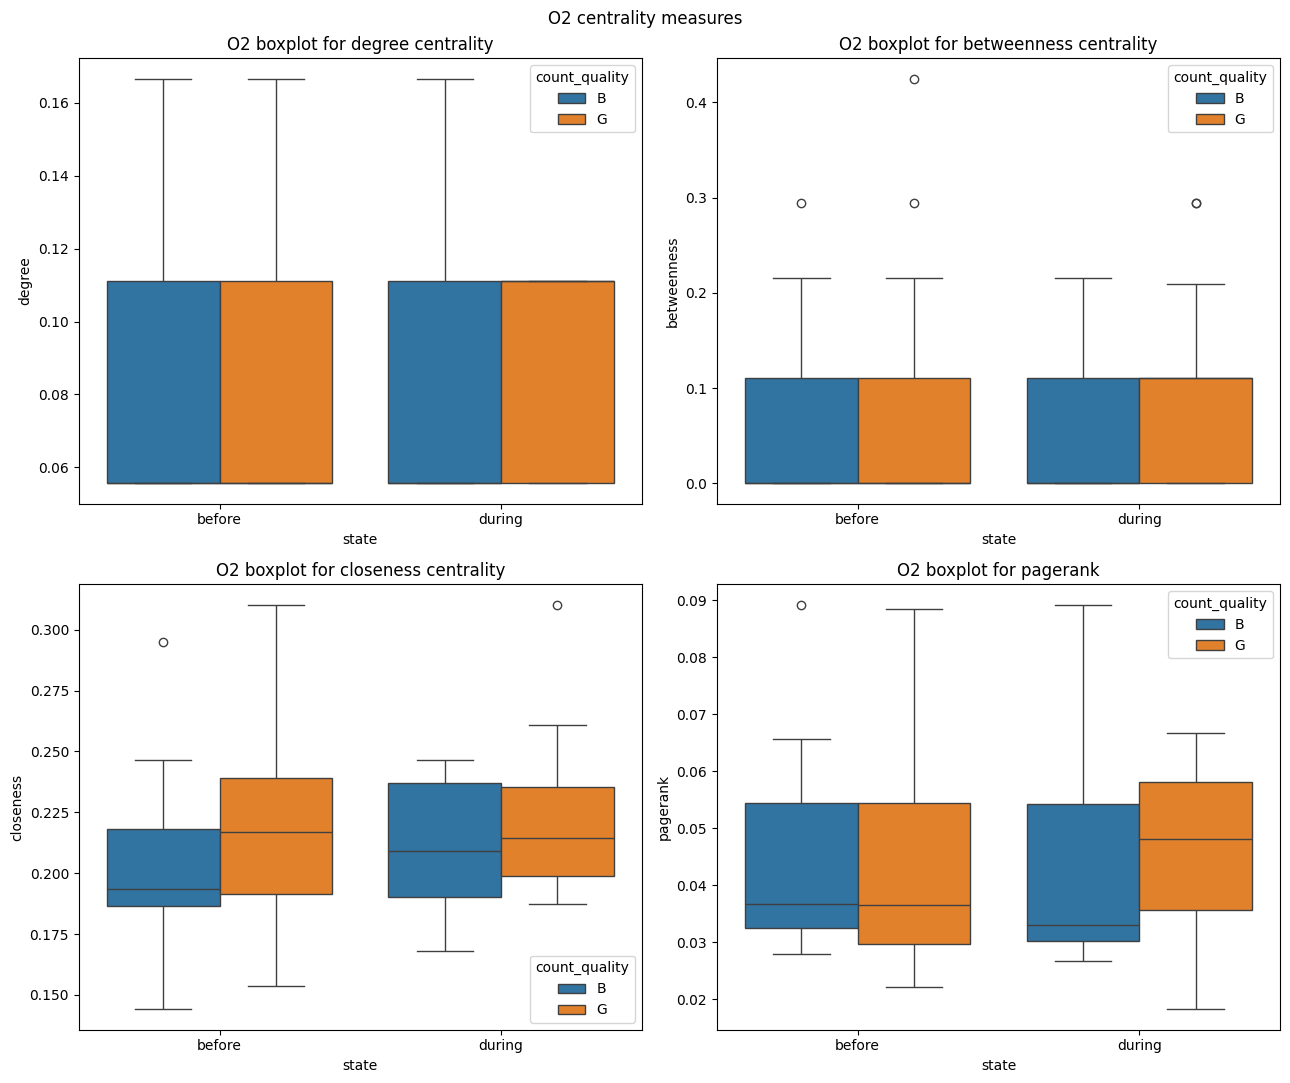

In [58]:
boxplots('O2')

## Resto de Boxplots

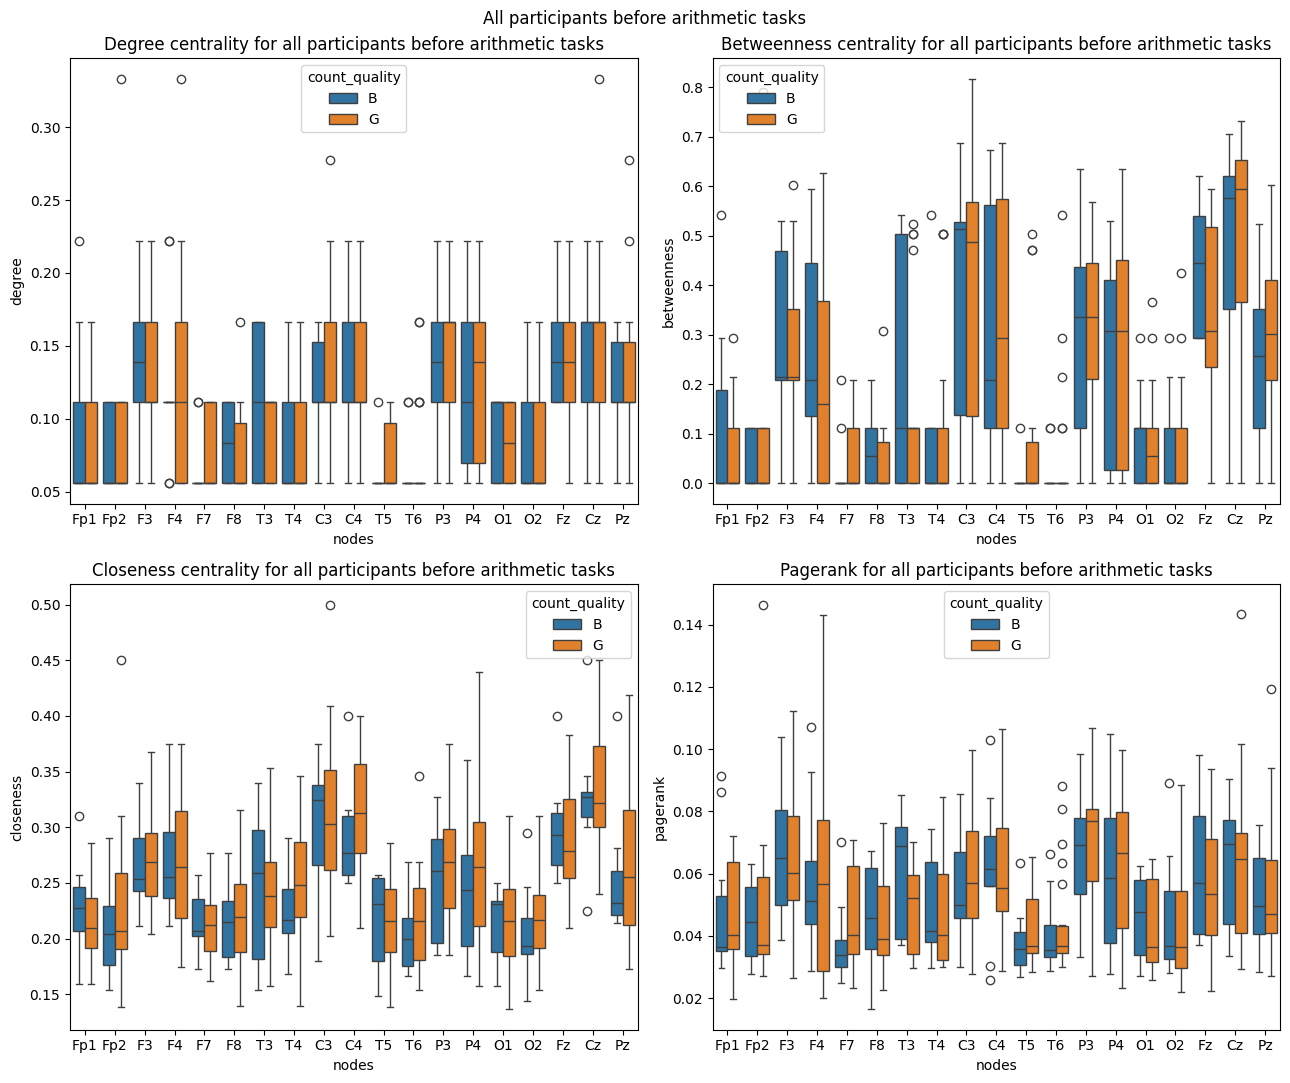

In [59]:
# Todos los nodos de los participantes antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before arithmetic tasks')

ax1.set_title('Degree centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

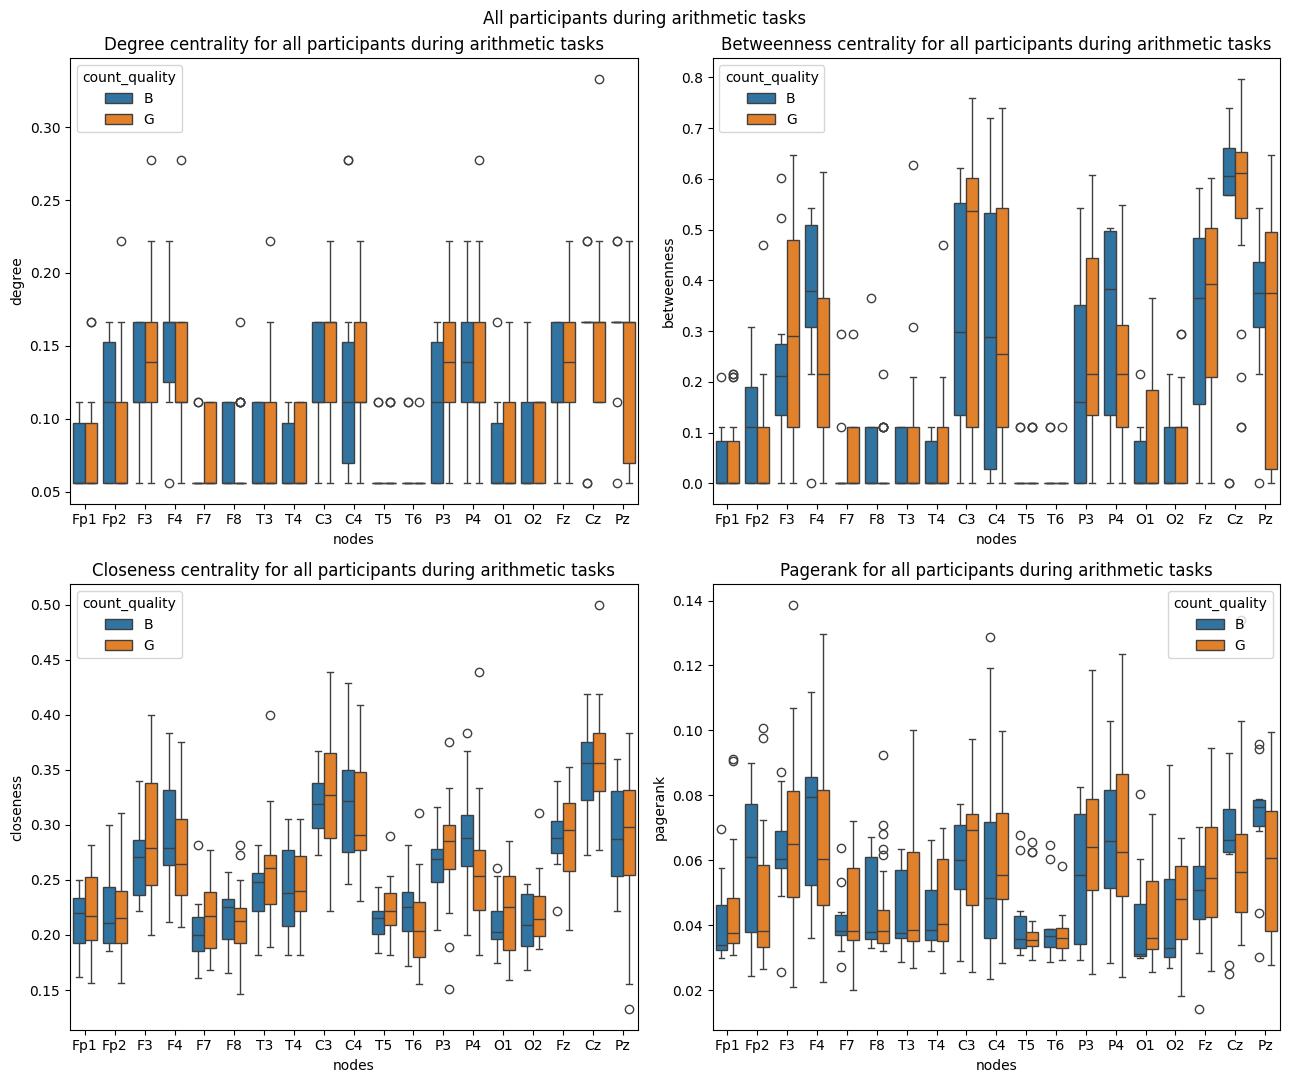

In [60]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

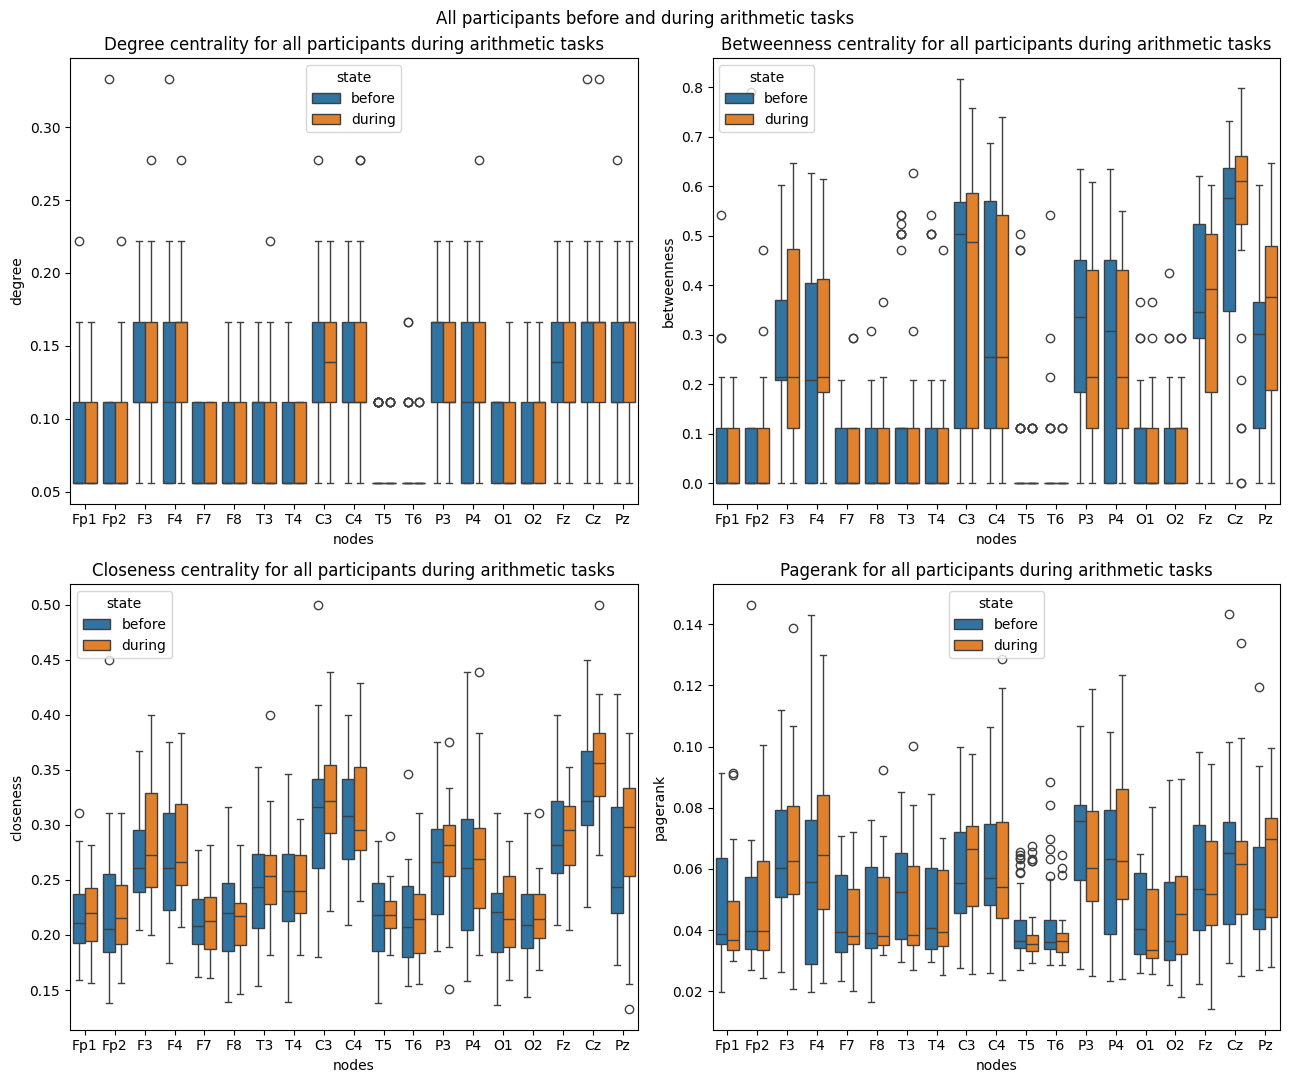

In [61]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before and during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='degree', hue='state', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='betweenness', hue='state', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='closeness', hue='state', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='pagerank', hue='state', ax=ax4
)

plt.tight_layout()

# Promedio

In [62]:
# Funciones para graficar

# Función para generar el grafo con las distancias

def plot_mst_distances(mst_ave_before: nx.Graph, mst_ave_during: nx.Graph, title: str) -> None:
    # Generar la base de los grafos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 7))
    fig.suptitle(title)

    for ax in (ax1, ax2):
        ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1.5))
        ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

        # Agregar segmentos
        ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)
        ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1.5, zorder=0)

    # Agregar a la izquierda el mst para antes
    ax1.set_title('Before')
    nx.draw_networkx(
        mst_ave_before,
        pos,
        ax = ax1,
        font_size=15,
        node_color='lightgreen'
    )

    nx.draw_networkx_edge_labels(
        mst_ave_before,
        pos,
        {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_before, 'weight').items()},
        ax=ax1
    )

    # Agregar a la derecha el mst para durante
    ax2.set_title('During')
    nx.draw_networkx(
        mst_ave_during,
        pos,
        ax=ax2,
        font_size=15,
        node_color='lightgreen'
    )

    nx.draw_networkx_edge_labels(
        mst_ave_during,
        pos,
        {pair: round(weight, 2) for pair, weight in nx.get_edge_attributes(mst_ave_during, 'weight').items()},
        ax=ax2
    )

    plt.tight_layout()
    plt.show()

In [68]:
# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

def get_node_color(i: int, measure: str, df_centrality: pd.DataFrame) -> tuple:
    measure_centrality = df_centrality.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G: nx.Graph, measure: str, df_centrality: pd.DataFrame, ax) -> None:
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    # Agregar la base del grafo
    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1, zorder=0)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1, zorder=0)


    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure, df_centrality) for i, _ in enumerate(G.nodes)],
        labels=temp_labels
    )

    ax.set_title(f'{measure.title()} centrality')

def plot_all_measures(mst: nx.Graph, df_centrality: pd.DataFrame, title: str) -> None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Degree
    plot_measure(mst, 'degree', df_centrality, ax1)

    # Betweenness
    plot_measure(mst, 'betweenness', df_centrality, ax2)

    # Closeness
    plot_measure(mst, 'closeness', df_centrality, ax3)

    # Pagerank
    plot_measure(mst, 'pagerank', df_centrality, ax4)

    fig.suptitle(title)
    plt.tight_layout()

    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, label='Centrality', ax=(ax1, ax2, ax3, ax4))

    plt.show()

## Promedio de todos los sujetos - Antes y durante

In [63]:
# Obtener el promedio de la matriz de distancias
n = 35 + 1

ave_before = np.zeros((19, 19))
ave_during = np.zeros((19, 19))

for i in range(n):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    ave_before += get_distances(csv_path1)
    ave_during += get_distances(csv_path2)

ave_before /= n
ave_during /= n

df_centrality_ave_bef = get_centrality_from_df(ave_before)
df_centrality_ave_dur = get_centrality_from_df(ave_during)

ave_before.to_csv('Archivos\\ave_distances_before.csv', sep=';', index=False)
ave_during.to_csv('Archivos\\ave_distances_during.csv', sep=';', index=False)

df_centrality_ave_bef.to_csv('Archivos\\ave_centrality_before.csv', sep=';', index=False)
df_centrality_ave_dur.to_csv('Archivos\\ave_centrality_during.csv', sep=';', index=False)

In [64]:
df_centrality_ave_bef = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_bef['status'] = 'before'

df_centrality_ave_dur = pd.read_csv('Archivos\\ave_centrality_during.csv', delimiter=';')
df_centrality_ave_dur['status'] = 'during'

df_centrality_ave = pd.concat([df_centrality_ave_bef, df_centrality_ave_dur], ignore_index=True)

ave_before = pd.read_csv('Archivos\\ave_distances_before.csv', delimiter=';')
ave_before.index = CHANNELS

ave_during = pd.read_csv('Archivos\\ave_distances_during.csv', delimiter=';')
ave_during.index = CHANNELS

display(df_centrality_ave_bef.head(), df_centrality_ave_dur.head())
display(ave_before.head(), ave_during.head())

nodes    degree  betweenness  closeness  pagerank  status
0   Fp1  0.055556     0.000000   0.216867  0.034418  before
1   Fp2  0.055556     0.000000   0.216867  0.035438  before
2    F3  0.166667     0.215686   0.272727  0.082833  before
3    F4  0.166667     0.215686   0.272727  0.083693  before
4    F7  0.055556     0.000000   0.216867  0.034693  before

nodes    degree  betweenness  closeness  pagerank  status
0   Fp1  0.055556     0.000000   0.219512  0.035627  during
1   Fp2  0.055556     0.000000   0.219512  0.035204  during
2    F3  0.166667     0.215686   0.276923  0.084052  during
3    F4  0.166667     0.215686   0.276923  0.084196  during
4    F7  0.055556     0.000000   0.219512  0.034965  during

Fp1       Fp2        F3        F4        F7        F8        T3  \
Fp1  0.000000  0.966750  0.753063  0.895140  0.782608  1.081611  1.030000   
Fp2  0.966750  0.000000  0.894362  0.794862  1.086167  0.806985  1.191053   
F3   0.753063  0.894362  0.000000  0.644838  0.760892  0.957916  0.860003   
F4   0.895140  0.794862  0.644838  0.000000  0.986030  0.771889  1.031400   
F7   0.782608  1.086167  0.760892  0.986030  0.000000  1.150666  0.958963   

           T4        C3        C4        T5        T6        P3        P4  \
Fp1  1.182597  0.992317  1.052308  1.190921  1.362044  1.213450  1.274575   
Fp2  1.077521  1.062204  1.001154  1.334805  1.279051  1.258558  1.237585   
F3   1.038424  0.688389  0.804227  1.091273  1.267879  1.039769  1.107170   
F4   0.872287  0.808719  0.695457  1.216308  1.162186  1.103849  1.059815   
F7   1.222708  0.967527  1.088323  1.126716  1.384490  1.174703  1.259690   

           O1        O2        Fz        Cz        Pz  
Fp1  1.371777  1.392200  0.821530  0.990022  1.226651  
Fp2  1.398181  1.376156  0.814010  1.003633  1.236774  
F3   1.271747  1.287946  0.485101  0.695420  1.058354  
F4   1.298971  1.275471  0.486213  0.688271  1.065467  
F7   1.340095  1.370689  0.892047  1.015620  1.213153

Fp1       Fp2        F3        F4        F7        F8        T3  \
Fp1  0.000000  1.011630  0.853269  0.979507  0.874953  1.130377  1.068363   
Fp2  1.011630  0.000000  0.928222  0.841802  1.100883  0.871733  1.166162   
F3   0.853269  0.928222  0.000000  0.644904  0.832875  0.992509  0.829227   
F4   0.979507  0.841802  0.644904  0.000000  1.012554  0.848659  0.985038   
F7   0.874953  1.100883  0.832875  1.012554  0.000000  1.175635  0.973035   

           T4        C3        C4        T5        T6        P3        P4  \
Fp1  1.218230  1.036585  1.100308  1.190607  1.324744  1.209817  1.252216   
Fp2  1.088594  1.092114  1.038934  1.282659  1.248019  1.239973  1.217687   
F3   1.027603  0.683122  0.782273  1.052972  1.208957  0.987588  1.060274   
F4   0.882198  0.796840  0.685668  1.158580  1.109613  1.051015  1.020814   
F7   1.209377  0.986807  1.100332  1.142153  1.336290  1.172267  1.235130   

           O1        O2        Fz        Cz        Pz  
Fp1  1.333534  1.357507  0.913875  1.045555  1.232604  
Fp2  1.344820  1.335552  0.884223  1.035932  1.236140  
F3   1.208118  1.240036  0.512082  0.681278  1.026049  
F4   1.234741  1.226086  0.515590  0.679834  1.033274  
F7   1.319366  1.341880  0.940802  1.034341  1.205422

In [65]:
mst_ave_before = get_mst_from_df(ave_before)
mst_ave_during = get_mst_from_df(ave_during)

for i, node in enumerate(CHANNELS):
    mst_ave_before.nodes[node]['degree'] = round(df_centrality_ave_bef['degree'][i], 2)
    mst_ave_before.nodes[node]['betweenness'] = round(df_centrality_ave_bef['betweenness'][i], 2)
    mst_ave_before.nodes[node]['closeness'] = round(df_centrality_ave_bef['closeness'][i], 2)
    mst_ave_before.nodes[node]['pagerank'] = round(df_centrality_ave_bef['pagerank'][i], 2)

    mst_ave_during.nodes[node]['degree'] = round(df_centrality_ave_dur['degree'][i], 2)
    mst_ave_during.nodes[node]['betweenness'] = round(df_centrality_ave_dur['betweenness'][i], 2)
    mst_ave_during.nodes[node]['closeness'] = round(df_centrality_ave_dur['closeness'][i], 2)
    mst_ave_during.nodes[node]['pagerank'] = round(df_centrality_ave_dur['pagerank'][i], 2)

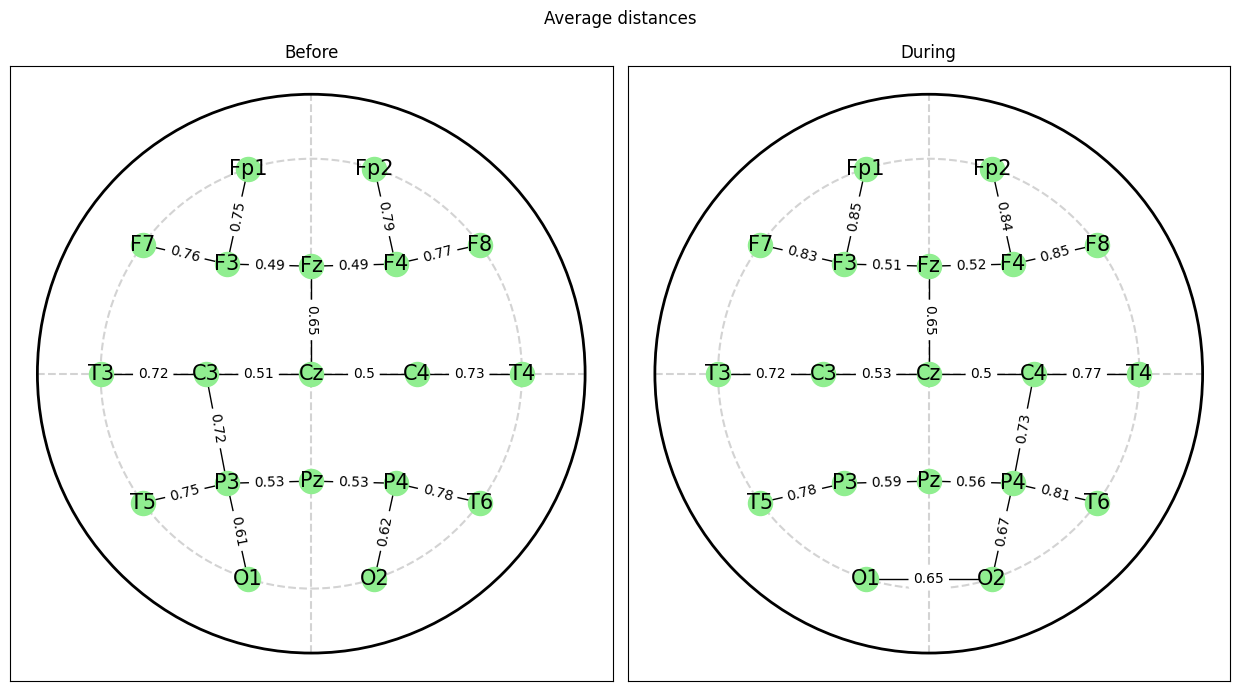

In [66]:
plot_mst_distances(mst_ave_before, mst_ave_during, 'Average distances')

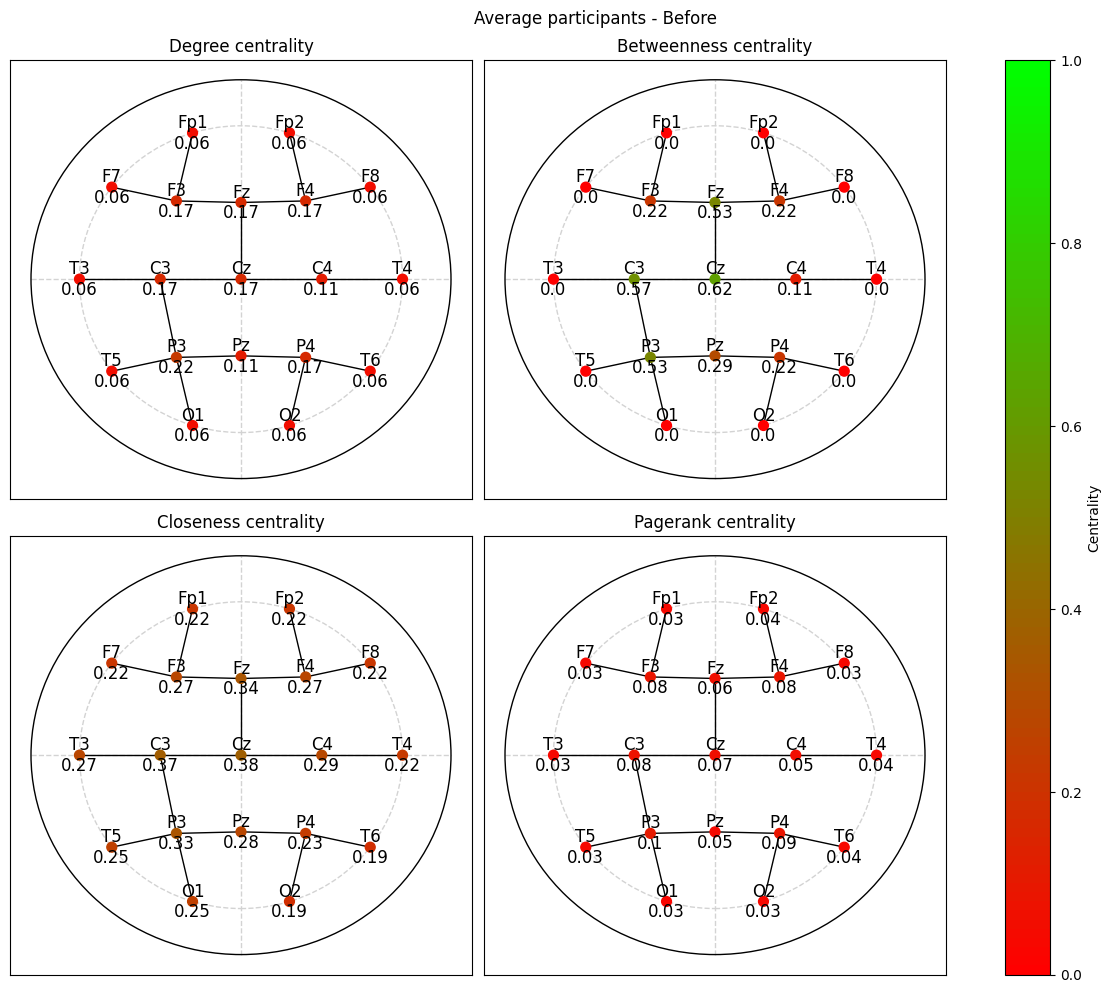

In [69]:
# Promedio de todos los participantes - antes

plot_all_measures(mst_ave_before, df_centrality_ave_bef, 'Average participants - Before')

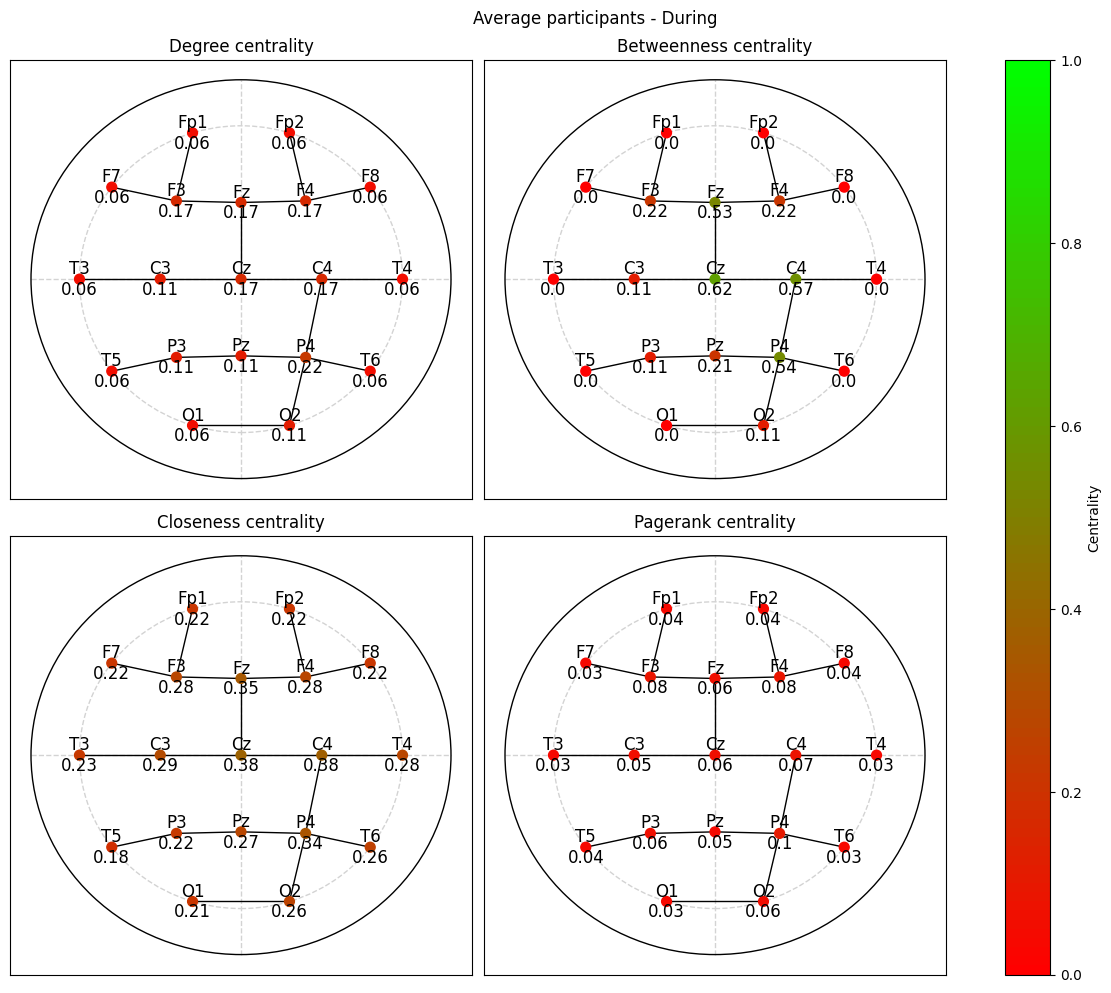

In [70]:
# Promedio de todos los participantes - durante
plot_all_measures(mst_ave_during, df_centrality_ave_dur, 'Average participants - During')

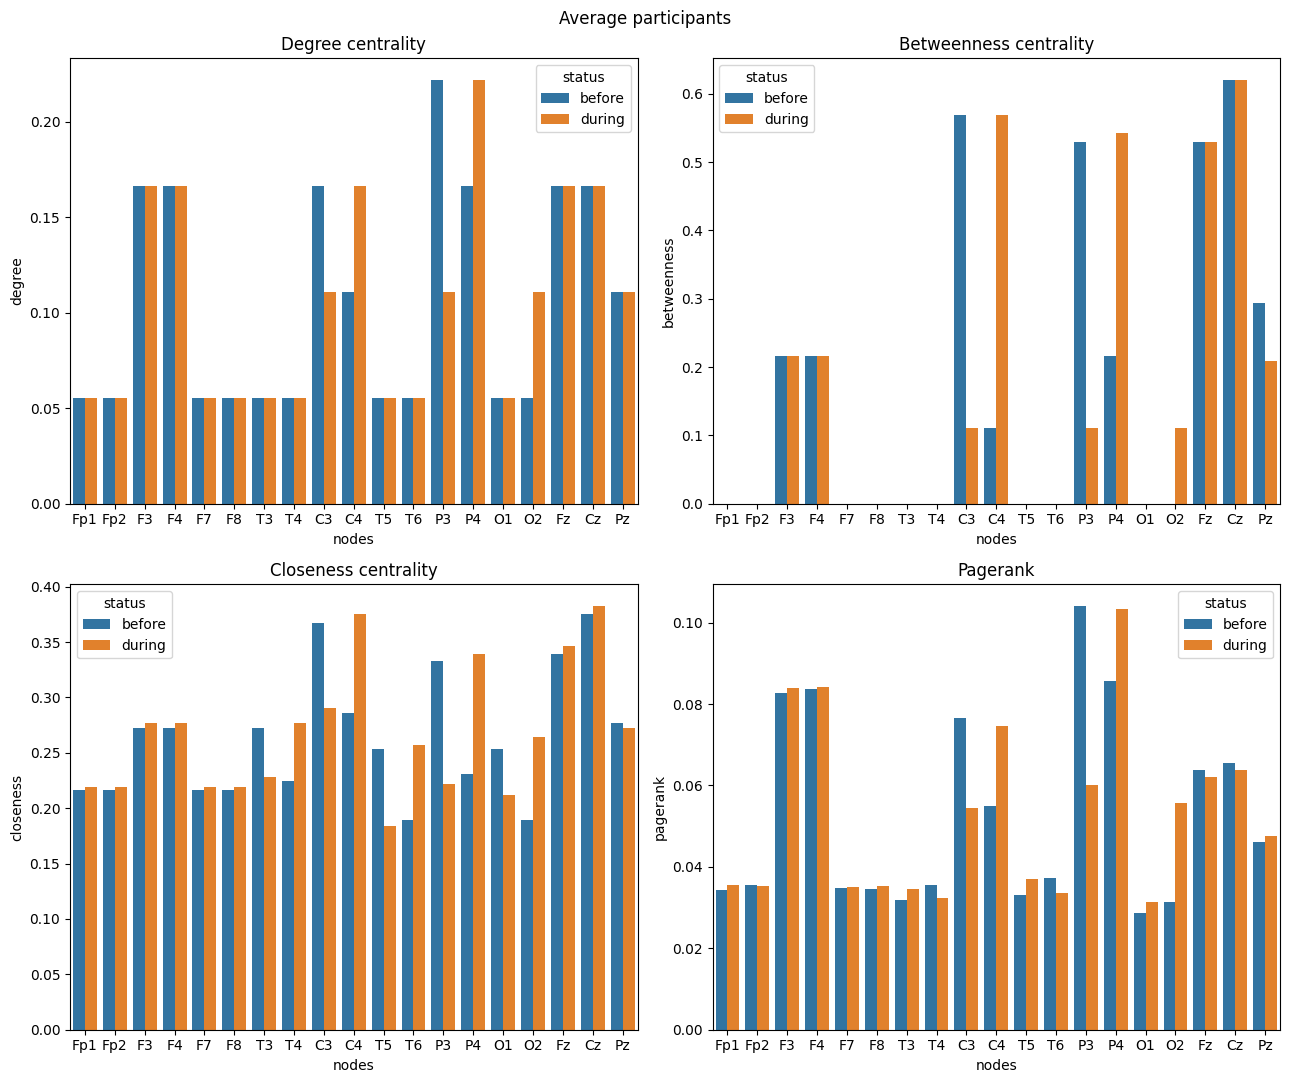

In [71]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants')

ax1.set_title('Degree centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='degree', hue='status', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='betweenness', hue='status', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='closeness', hue='status', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_centrality_ave, x='nodes', y='pagerank', hue='status', ax=ax4
)

plt.tight_layout()

### Boxplots para las distancias con mayor diferencia en los grafos de promedio

En base al gráfico obtenido, las distancias que más tuvieron diferencias fueron

- Fp1 - F3  
Antes: 0.75  
Durante: 0.86  

- F7 - F3  
Antes: 0.76  
Durante: 0.84  

- F4 - F8:  
Antes: 0.77  
Durante: 0.85

In [72]:
N = 36

# [Datos_antes, Datos_durante]
fp1_to_f3 = np.zeros((2, N), dtype=float)
f7_to_f3 = np.zeros((2, N), dtype=float)
f4_to_f8 = np.zeros((2, N), dtype=float)

for i in range(N):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    temp_before = get_distances(csv_path1)
    temp_during = get_distances(csv_path2)

    fp1_to_f3[0][i], fp1_to_f3[1][i] = temp_before['Fp1']['F3'], temp_during['Fp1']['F3']
    f7_to_f3[0][i], f7_to_f3[1][i] = temp_before['F7']['F3'], temp_during['F7']['F3']
    f4_to_f8[0][i], f4_to_f8[1][i] = temp_before['F4']['F8'], temp_during['F4']['F8']

In [73]:
def generate_df(array: np.ndarray, name: str) -> pd.DataFrame:
    df_bef: pd.DataFrame = pd.DataFrame({
        'pair': [name]*N, 'status': ['before']*N, 'distance': array[0]
    })

    df_dur: pd.DataFrame = pd.DataFrame({
        'pair': [name]*N, 'status': ['during']*N, 'distance': array[1]
    })

    return pd.concat([df_bef, df_dur], ignore_index=True)

df_fp1_to_f3 = generate_df(fp1_to_f3, 'Fp1 - F3')
df_f7_to_f3 = generate_df(f7_to_f3, 'F7 - F3')
df_f4_to_f8 = generate_df(f4_to_f8, 'F4 - F8')

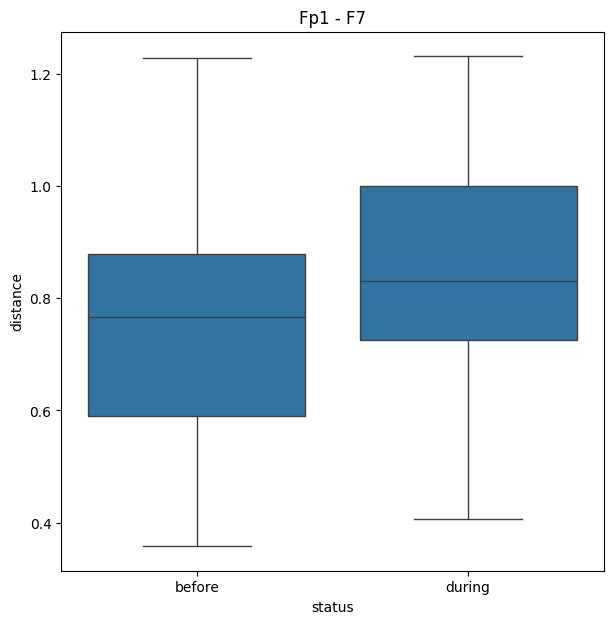

In [74]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('Fp1 - F7')

sns.boxplot(
    df_fp1_to_f3, x='status', y='distance', ax=ax
)

plt.show()

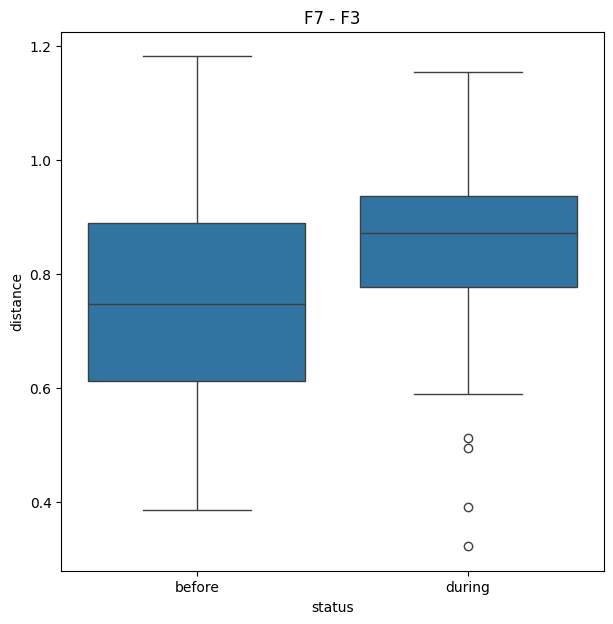

In [75]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('F7 - F3')

sns.boxplot(
    df_f7_to_f3, x='status', y='distance', ax=ax
)

plt.show()

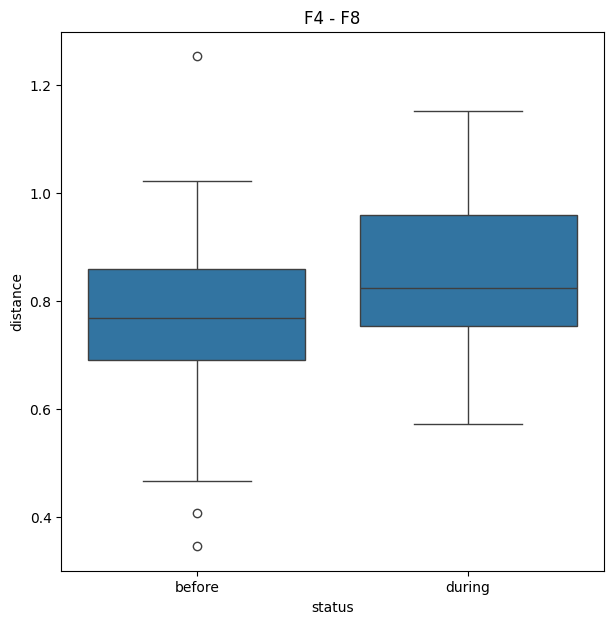

In [76]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title('F4 - F8')

sns.boxplot(
    df_f4_to_f8, x='status', y='distance', ax=ax
)

plt.show()

## Promedio personas basado en su calidad de conteo - Antes y durante

In [77]:
# Promedio de las personas dependiendo de su calidad de conteo (antes y durante)

ave_b_before, ave_g_before = np.zeros((19, 19)), np.zeros((19, 19))
ave_b_during, ave_g_during = np.zeros((19, 19)), np.zeros((19, 19))
n_b, n_g = 0, 0

for i in range(35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    if df_subject_info['Count quality'][i] == 1:
        ave_g_before += get_distances(csv_path1)
        ave_g_during += get_distances(csv_path2)
        n_g += 1
    else:
        ave_b_before += get_distances(csv_path1)
        ave_b_during += get_distances(csv_path2)
        n_b += 1

ave_g_before /= n_g
ave_g_during /= n_g
ave_b_before /= n_b
ave_b_during /= n_b

df_centrality_ave_g_before = get_centrality_from_df(ave_g_before)
df_centrality_ave_g_during = get_centrality_from_df(ave_g_during)
df_centrality_ave_b_before = get_centrality_from_df(ave_b_before)
df_centrality_ave_b_during = get_centrality_from_df(ave_b_during)

df_centrality_ave_g_before['status'] = 'before'
df_centrality_ave_g_during['status'] = 'during'
df_centrality_ave_b_before['status'] = 'before'
df_centrality_ave_b_during['status'] = 'during'

df_centrality_ave_g = pd.concat([df_centrality_ave_g_before, df_centrality_ave_g_during], ignore_index=True)
df_centrality_ave_b = pd.concat([df_centrality_ave_b_before, df_centrality_ave_b_during], ignore_index=True)

ave_g_before.to_csv('Archivos\\ave_distances_good_before.csv', sep=';', index=False)
ave_b_before.to_csv('Archivos\\ave_distances_bad_before.csv', sep=';', index=False)
ave_g_during.to_csv('Archivos\\ave_distances_good_during.csv', sep=';', index=False)
ave_b_during.to_csv('Archivos\\ave_distances_bad_during.csv', sep=';', index=False)

df_centrality_ave_g.to_csv('Archivos\\ave_centrality_good.csv', sep=';', index=False)
df_centrality_ave_b.to_csv('Archivos\\ave_centrality_bad.csv', sep=';', index=False)

In [78]:
df_centrality_ave_g = pd.read_csv('Archivos\\ave_centrality_good.csv', delimiter=';')
df_centrality_ave_b = pd.read_csv('Archivos\\ave_centrality_bad.csv', delimiter=';')

df_centrality_ave_g['Count quality'] = 'G'
df_centrality_ave_b['Count quality'] = 'B'

df_centrality_ave_counts = pd.concat([df_centrality_ave_b, df_centrality_ave_g], ignore_index=True)

df_centrality_ave_g_before = df_centrality_ave_g[df_centrality_ave_g['status'] == 'before']
df_centrality_ave_b_before = df_centrality_ave_b[df_centrality_ave_b['status'] == 'before']
df_centrality_ave_g_during = df_centrality_ave_g[df_centrality_ave_g['status'] == 'during'].reset_index(drop=True)
df_centrality_ave_b_during = df_centrality_ave_b[df_centrality_ave_b['status'] == 'during'].reset_index(drop=True)

ave_g_before = pd.read_csv('Archivos\\ave_distances_good_before.csv', delimiter=';')
ave_g_before.index = CHANNELS

ave_b_before = pd.read_csv('Archivos\\ave_distances_bad_before.csv', delimiter=';')
ave_b_before.index = CHANNELS

ave_g_during = pd.read_csv('Archivos\\ave_distances_good_during.csv', delimiter=';')
ave_g_during.index = CHANNELS

ave_b_during = pd.read_csv('Archivos\\ave_distances_bad_during.csv', delimiter=';')
ave_b_during.index = CHANNELS

In [79]:
mst_ave_g_before = get_mst_from_df(ave_g_before)
mst_ave_g_during = get_mst_from_df(ave_g_during)
mst_ave_b_before = get_mst_from_df(ave_b_before)
mst_ave_b_during = get_mst_from_df(ave_b_during)

for i, node in enumerate(CHANNELS):
    mst_ave_g_before.nodes[node]['degree'] = round(df_centrality_ave_g_before['degree'][i], 2)
    mst_ave_g_before.nodes[node]['betweenness'] = round(df_centrality_ave_g_before['betweenness'][i], 2)
    mst_ave_g_before.nodes[node]['closeness'] = round(df_centrality_ave_g_before['closeness'][i], 2)
    mst_ave_g_before.nodes[node]['pagerank'] = round(df_centrality_ave_g_before['pagerank'][i], 2)

    mst_ave_g_during.nodes[node]['degree'] = round(df_centrality_ave_g_during['degree'][i], 2)
    mst_ave_g_during.nodes[node]['betweenness'] = round(df_centrality_ave_g_during['betweenness'][i], 2)
    mst_ave_g_during.nodes[node]['closeness'] = round(df_centrality_ave_g_during['closeness'][i], 2)
    mst_ave_g_during.nodes[node]['pagerank'] = round(df_centrality_ave_g_during['pagerank'][i], 2)

    mst_ave_b_before.nodes[node]['degree'] = round(df_centrality_ave_b_before['degree'][i], 2)
    mst_ave_b_before.nodes[node]['betweenness'] = round(df_centrality_ave_b_before['betweenness'][i], 2)
    mst_ave_b_before.nodes[node]['closeness'] = round(df_centrality_ave_b_before['closeness'][i], 2)
    mst_ave_b_before.nodes[node]['pagerank'] = round(df_centrality_ave_b_before['pagerank'][i], 2)

    mst_ave_b_during.nodes[node]['degree'] = round(df_centrality_ave_b_during['degree'][i], 2)
    mst_ave_b_during.nodes[node]['betweenness'] = round(df_centrality_ave_b_during['betweenness'][i], 2)
    mst_ave_b_during.nodes[node]['closeness'] = round(df_centrality_ave_b_during['closeness'][i], 2)
    mst_ave_b_during.nodes[node]['pagerank'] = round(df_centrality_ave_b_during['pagerank'][i], 2)

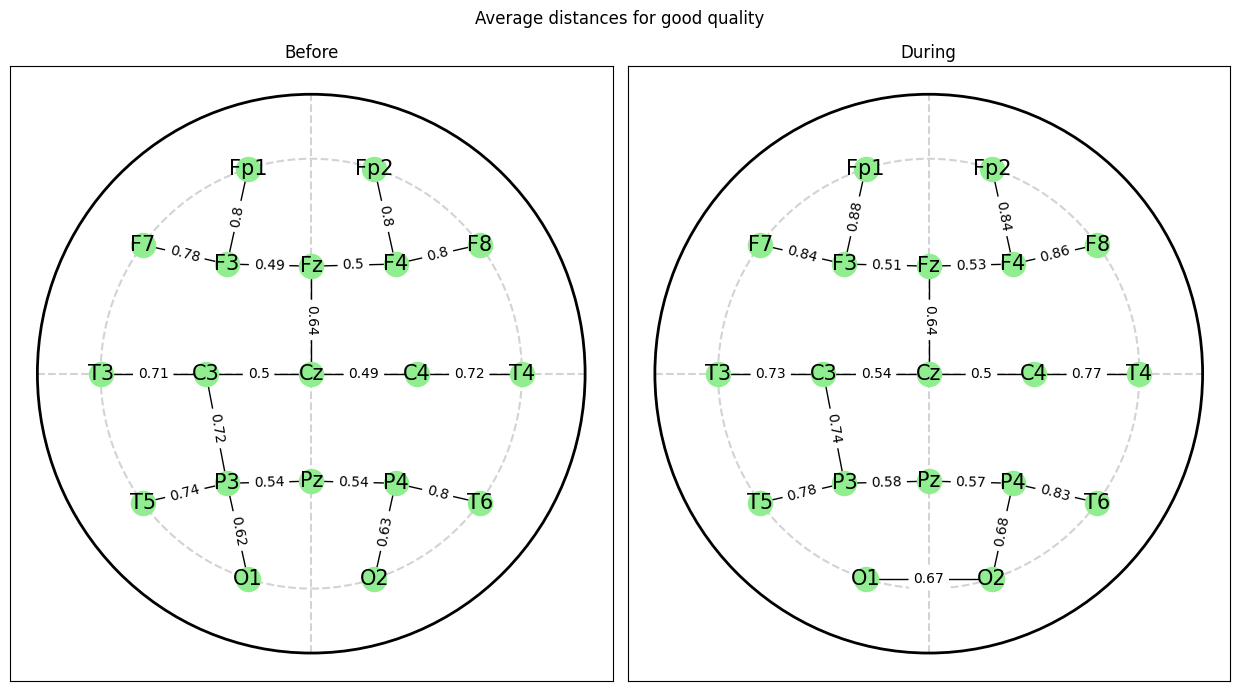

In [80]:
# MST para todos los buenos antes y durante

plot_mst_distances(mst_ave_g_before, mst_ave_g_during, 'Average distances for good quality')

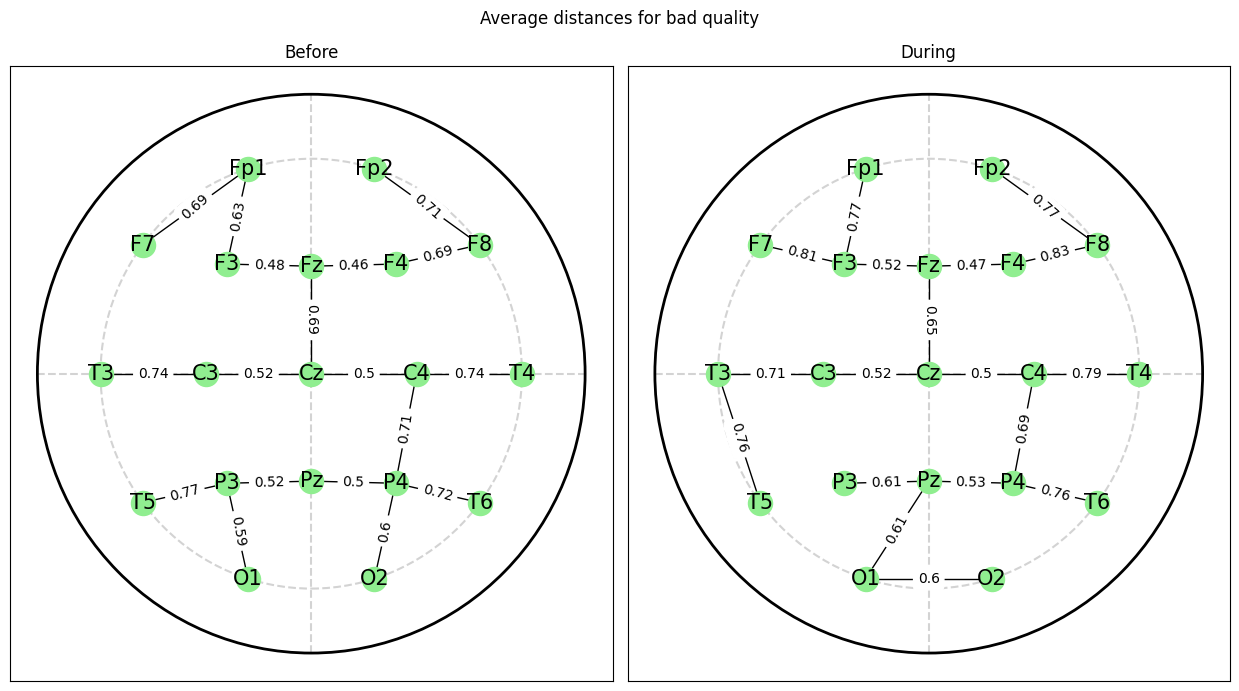

In [81]:
# MST para todos los buenos antes y durante
plot_mst_distances(mst_ave_b_before, mst_ave_b_during, 'Average distances for bad quality')

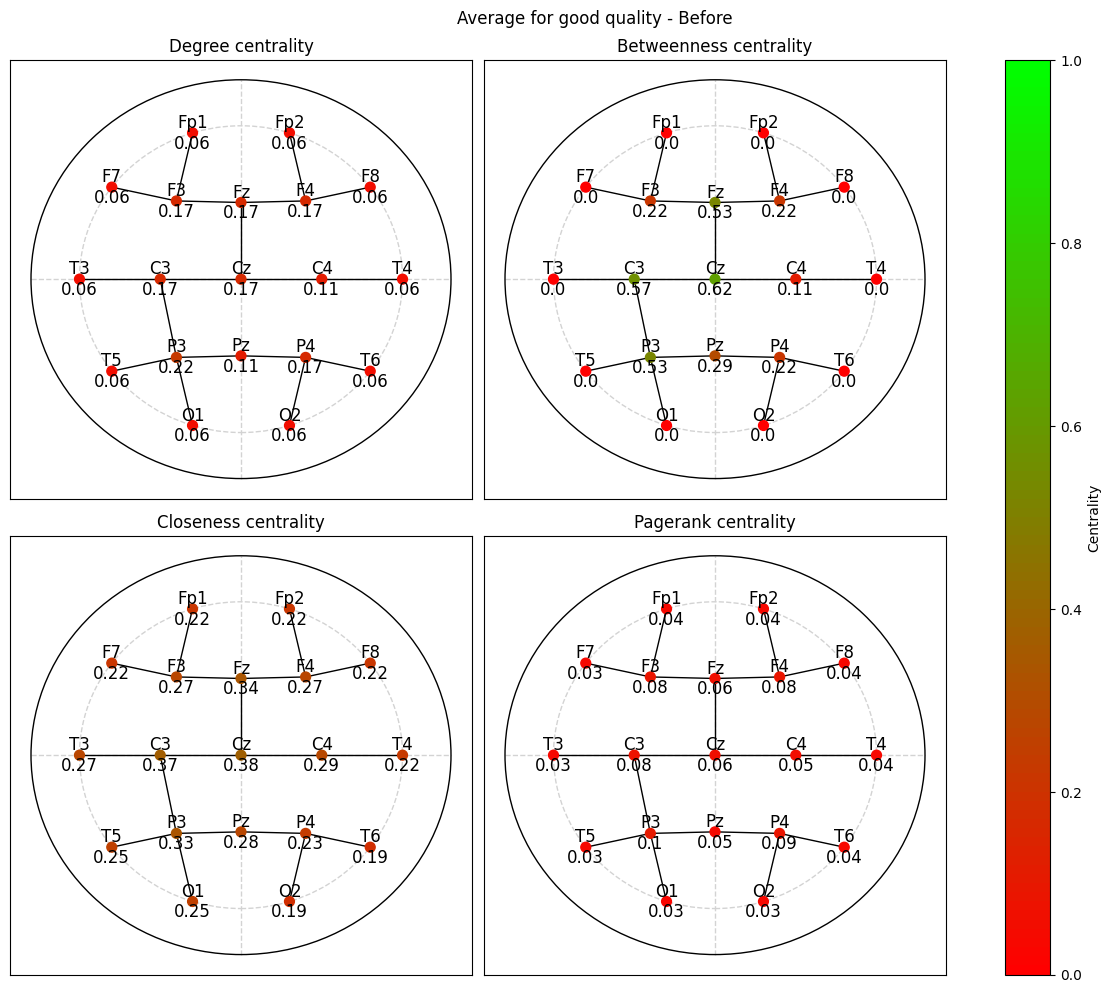

In [82]:
# Promedio de todos los buenos - antes

plot_all_measures(mst_ave_g_before, df_centrality_ave_g_before, 'Average for good quality - Before')

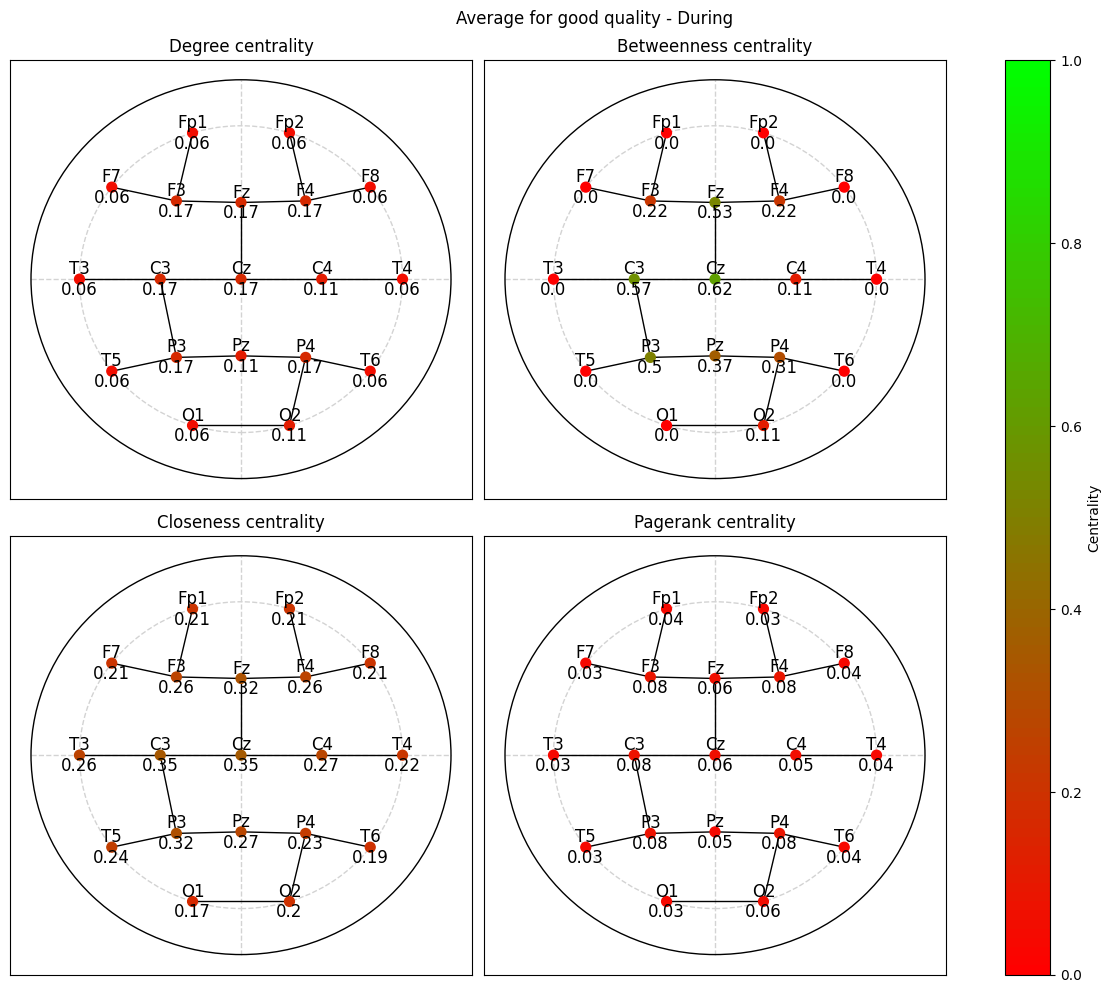

In [83]:
# Promedio de todos los buenos - durante

plot_all_measures(mst_ave_g_during, df_centrality_ave_g_during, 'Average for good quality - During')


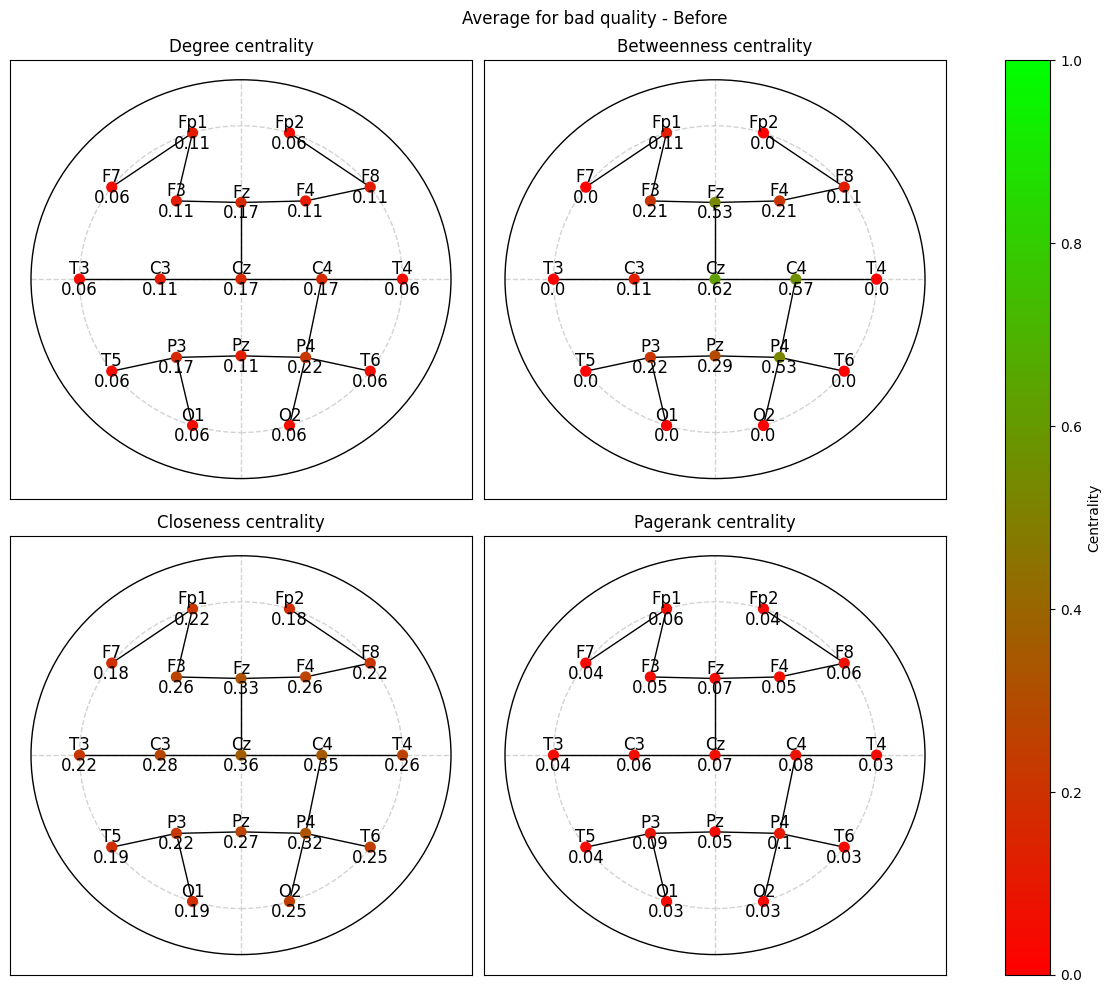

In [84]:
# Promedio de todos los malos - antes
plot_all_measures(mst_ave_b_before, df_centrality_ave_b_before, 'Average for bad quality - Before')

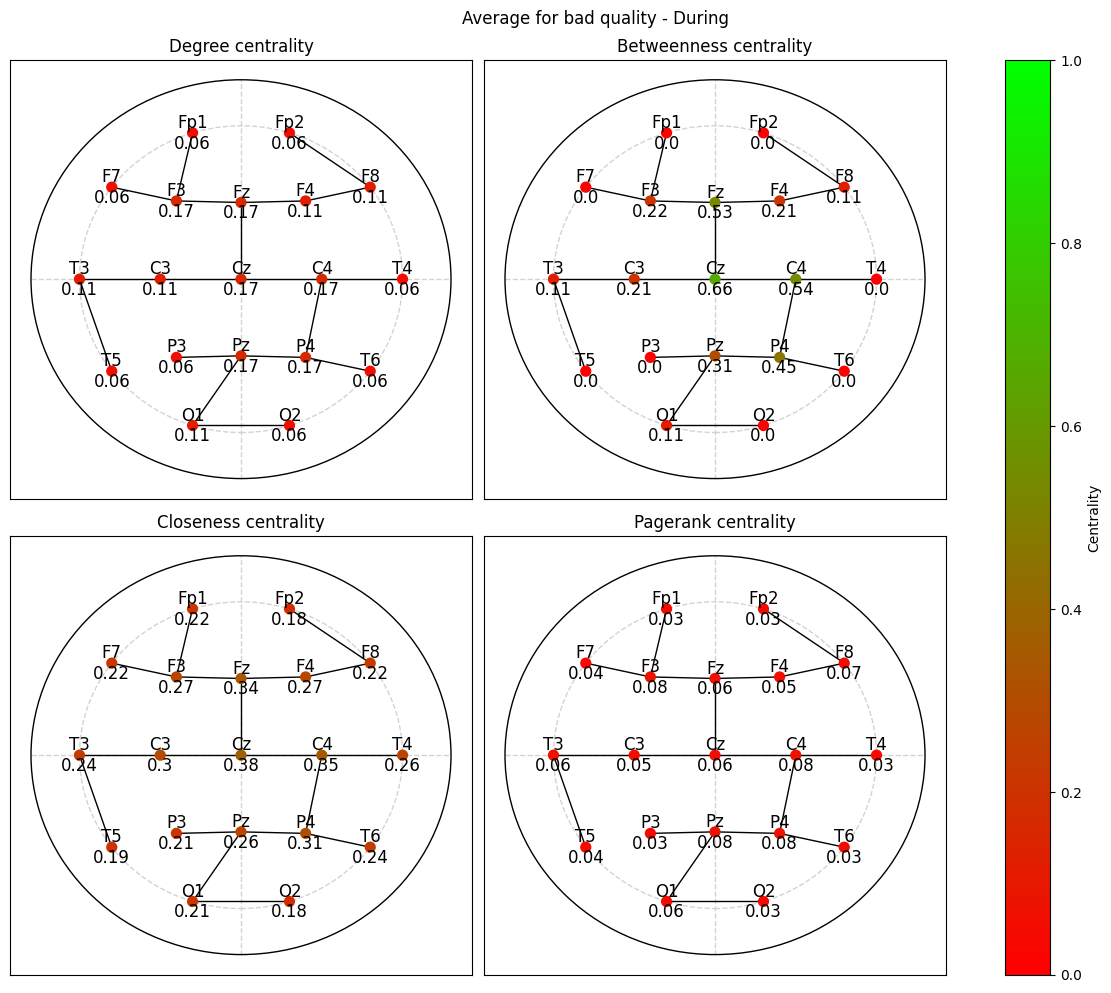

In [85]:
# Promedio de todos los malos - durante
plot_all_measures(mst_ave_b_during, df_centrality_ave_b_during, 'Average for bad quality - During')

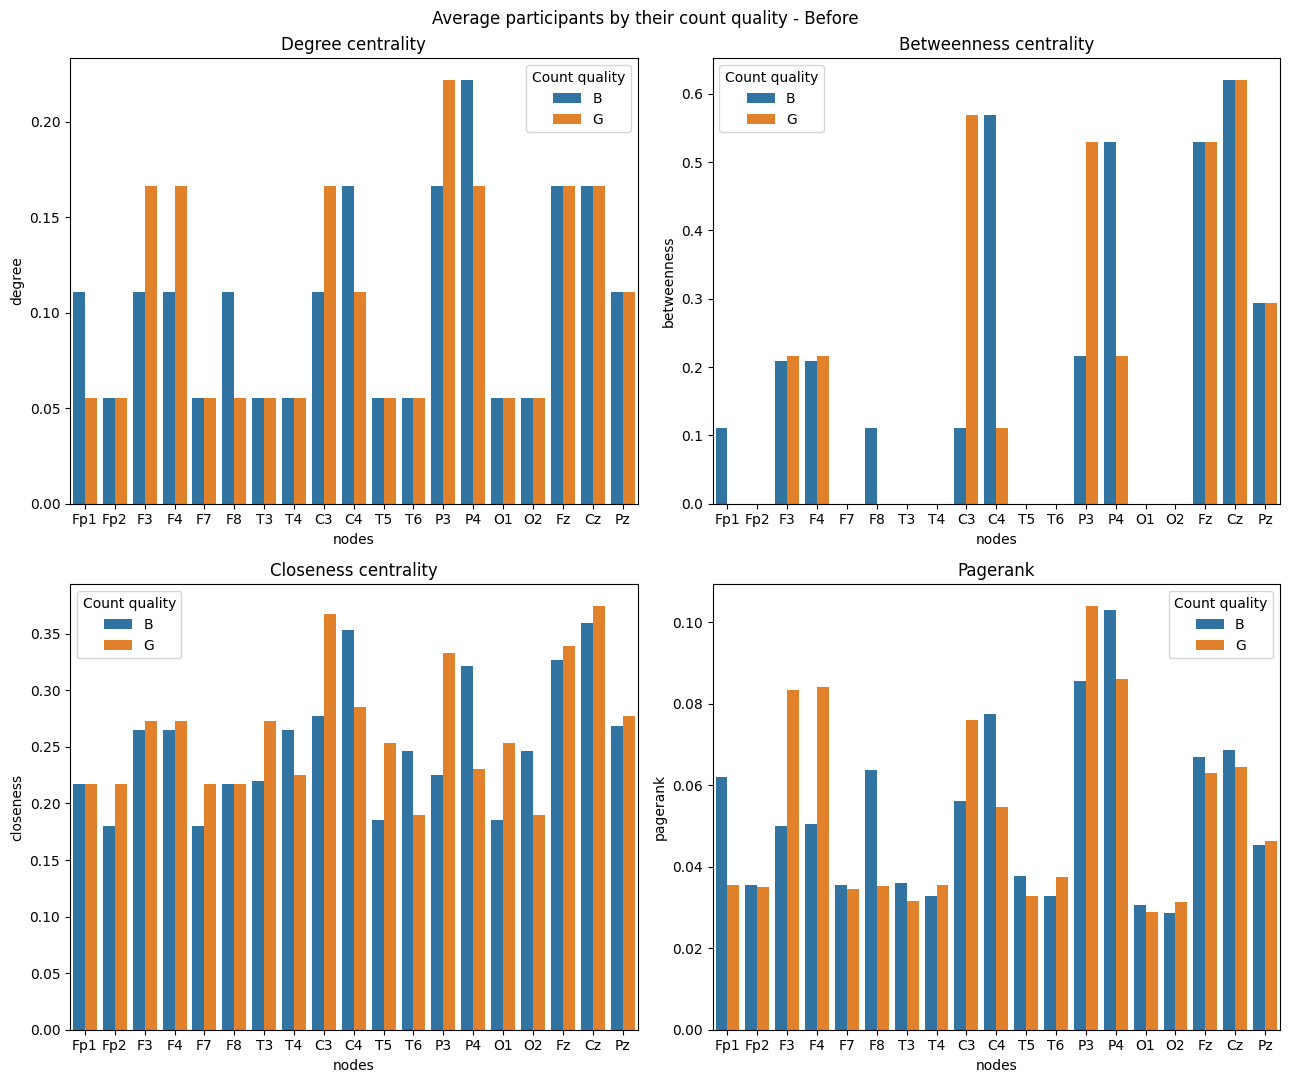

In [86]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'before']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - Before')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(    
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

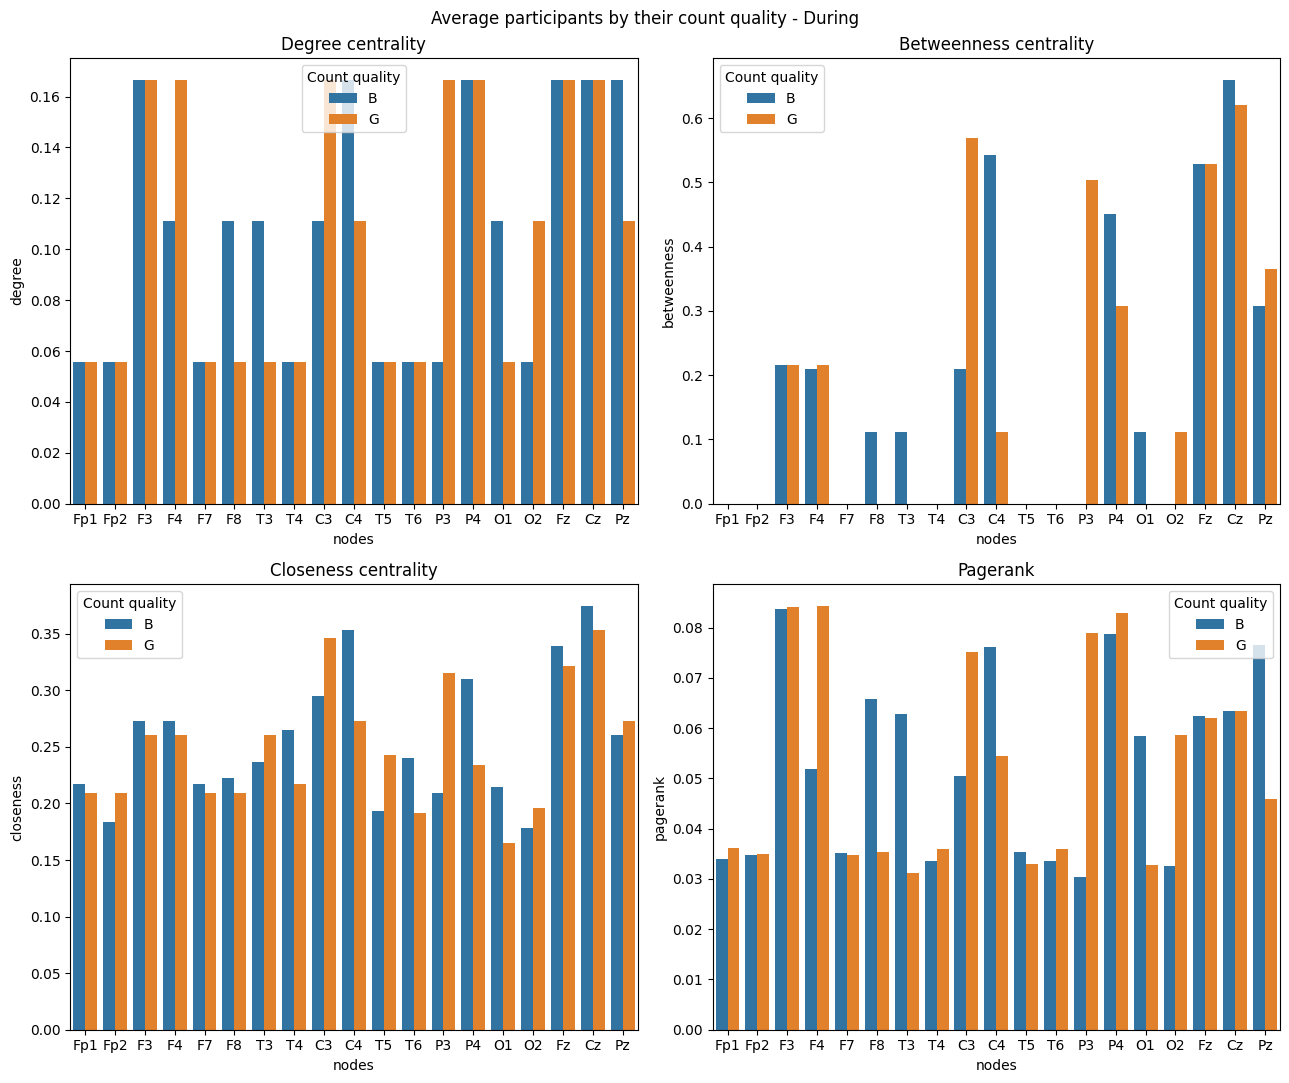

In [87]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'during']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - During')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

# Mapa topográfico

In [2]:
from ipywidgets import interact, FloatSlider
from IPython.display import display

In [92]:
N = 36

ave_signals = np.zeros((19, 122000), dtype=np.float32)
for i in range(N):
    if i in (4, 10, 31): continue # Descartar los casos con diferentes duraciones

    subject = f'Subject{i:02}'
    edf_path1 = f'Archivos\\{subject}\\edf\\{subject}_1.edf'
    edf_path2 = f'Archivos\\{subject}\\edf\\{subject}_2.edf'

    raw_before = mne.io.read_raw_edf(edf_path1)
    raw_during = mne.io.read_raw_edf(edf_path2)

    raw = mne.concatenate_raws([raw_before, raw_during])

    # Obtener los electrodos relevantes
    raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
    raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

    ave_signals += raw.get_data()

ave_signals /= N

Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject00\edf\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject01\edf\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject01\edf\Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject02\edf\Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting

In [93]:
info = mne.create_info(CHANNELS, ch_types=['eeg']*19, sfreq=500)
info.set_montage("standard_1020")

raw = mne.io.RawArray(ave_signals, info)
evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

display(info, evoked)

Creating RawArray with float64 data, n_channels=19, n_times=122000
    Range : 0 ... 121999 =      0.000 ...   243.998 secs
Ready.


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, F7, F8, T3, T4, C3, C4, T5, T6, P3, P4, O1, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>

<Evoked | '' (average, N=1), 0 – 244 s, baseline off, 19 ch, ~17.7 MB>

In [94]:
def plot_topomap(time):
    evoked.plot_topomap(
        times=time, ch_type='eeg', show_names=True, size=5
    )

slider = FloatSlider(value=0, min=0, max=(len(raw.times)-1)*2e-3, step=2e-3, description="Seconds")
interact(plot_topomap, time=slider)
display(slider)

interactive(children=(FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002), Outpu…

FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002)

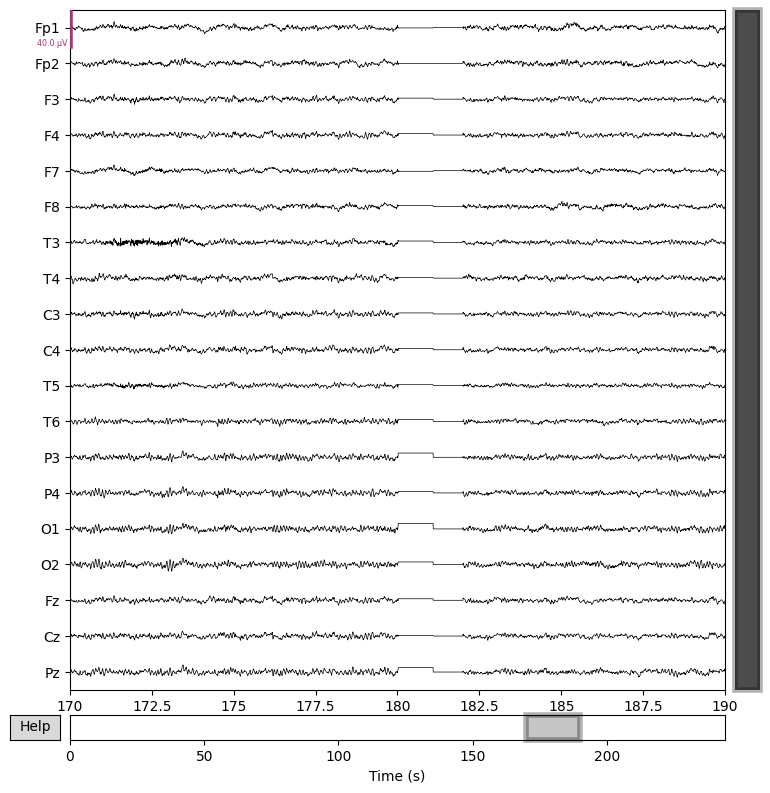

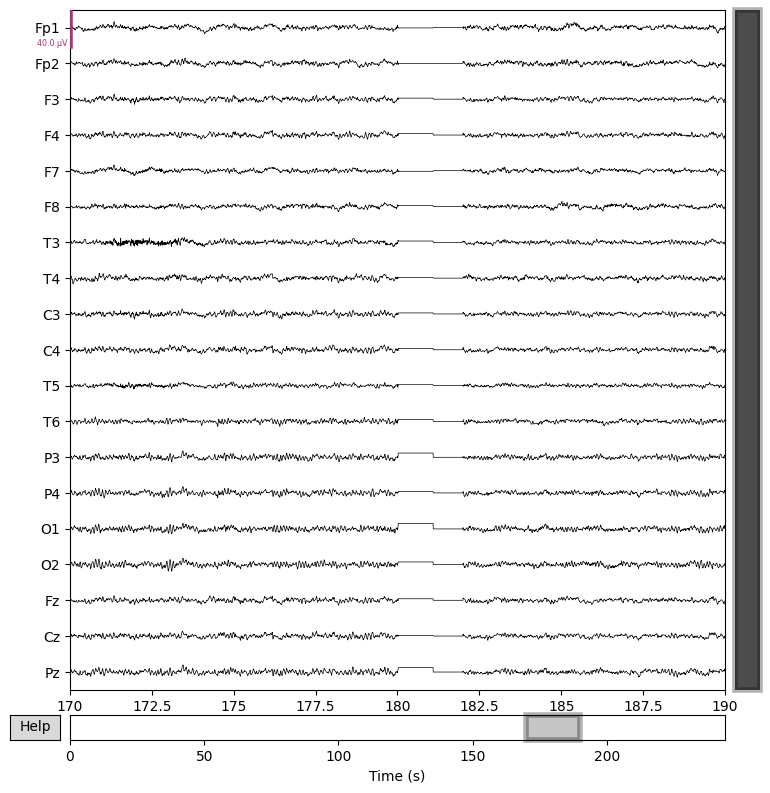

In [ ]:
raw.plot(start=170, duration=20)

Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\JuanD\Documents\vscode\semillero\Archivos\Subject00\edf\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


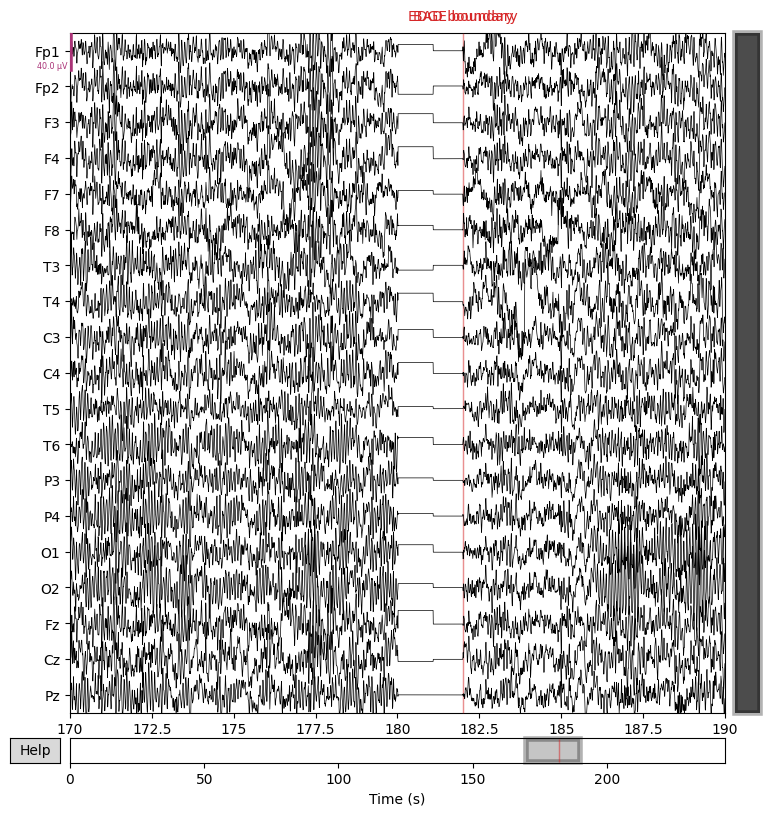

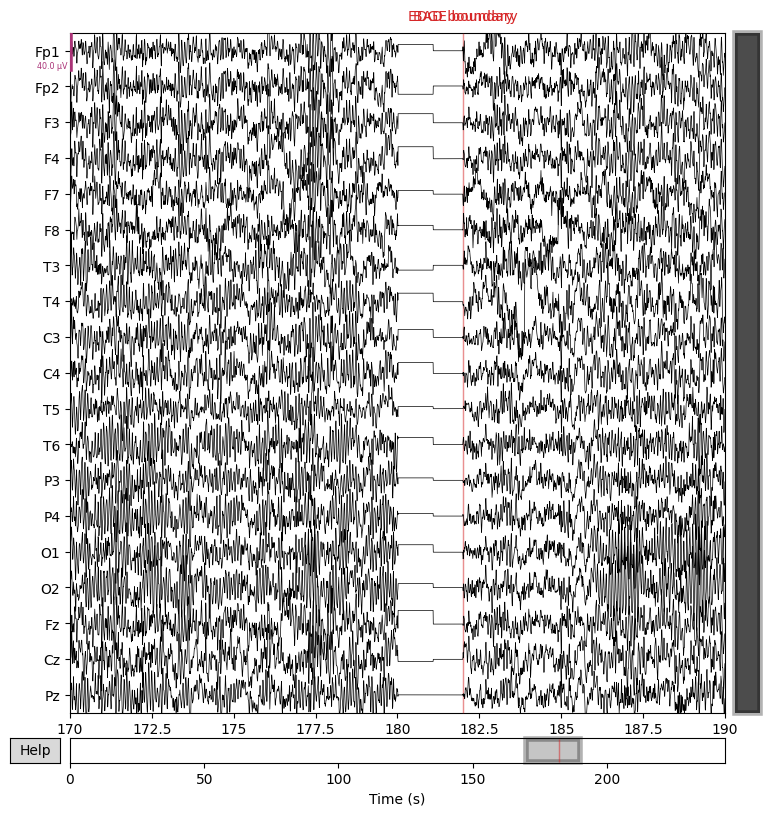

In [95]:
raw_0 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_1.edf')
raw_1 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_2.edf')

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

# Obtener los electrodos relevantes
raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

evoked: mne.Evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

montage = mne.channels.make_standard_montage("standard_1020")
evoked.info.set_montage(montage)

raw.plot(start=170, duration=20)

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


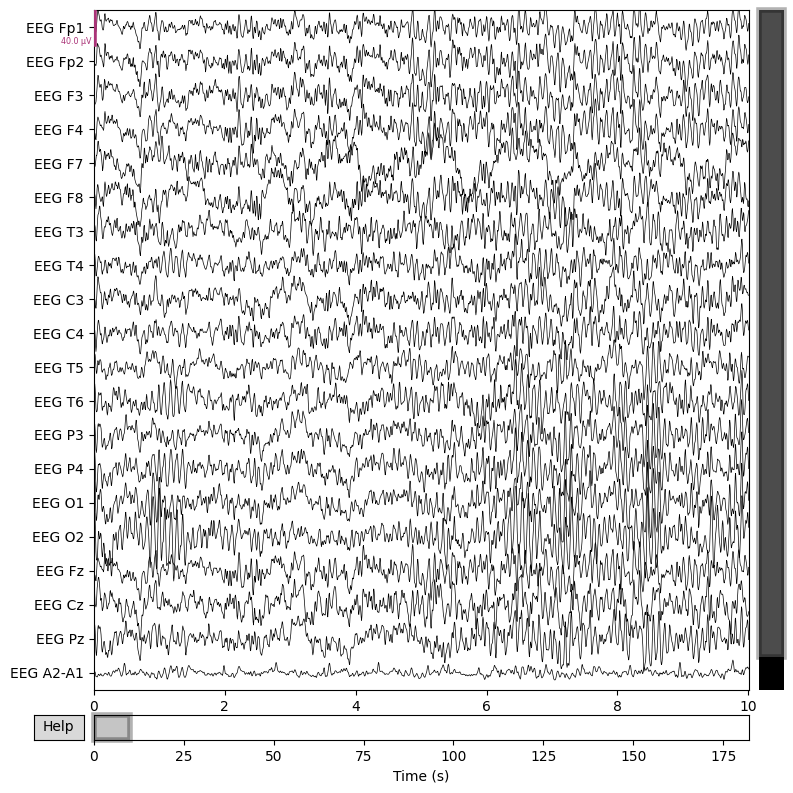

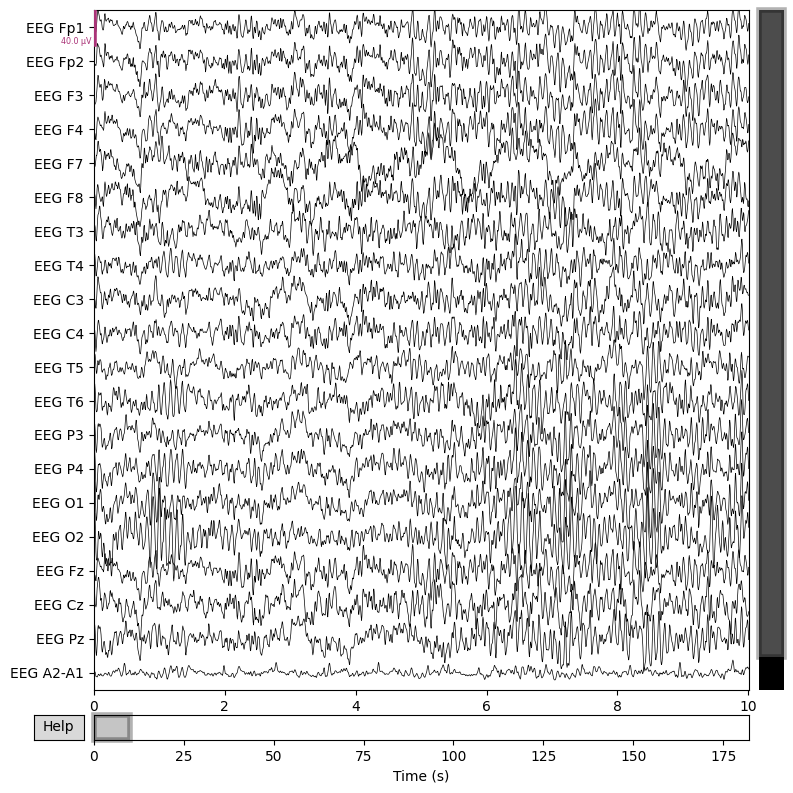

In [ ]:
mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_1.edf').plot()

In [8]:
# Crear el mismo resultado a partir de los csv's

df_1 = pd.read_csv('Archivos\Subject00\csv\Subject00_1.csv', sep=';')
df_2 = pd.read_csv('Archivos\Subject00\csv\Subject00_2.csv', sep=';')

info = mne.create_info(CHANNELS, ch_types=['eeg']*19, sfreq=500)
info.set_montage("standard_1020")

raw_0 = mne.io.RawArray(df_1, info)
raw_1 = mne.io.RawArray(df_2, info)

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

evoked

Creating RawArray with float64 data, n_channels=19, n_times=90000
    Range : 0 ... 89999 =      0.000 ...   179.998 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=30000
    Range : 0 ... 29999 =      0.000 ...    59.998 secs
Ready.


<Evoked | '' (average, N=1), 0 – 240 s, baseline off, 19 ch, ~17.4 MB>

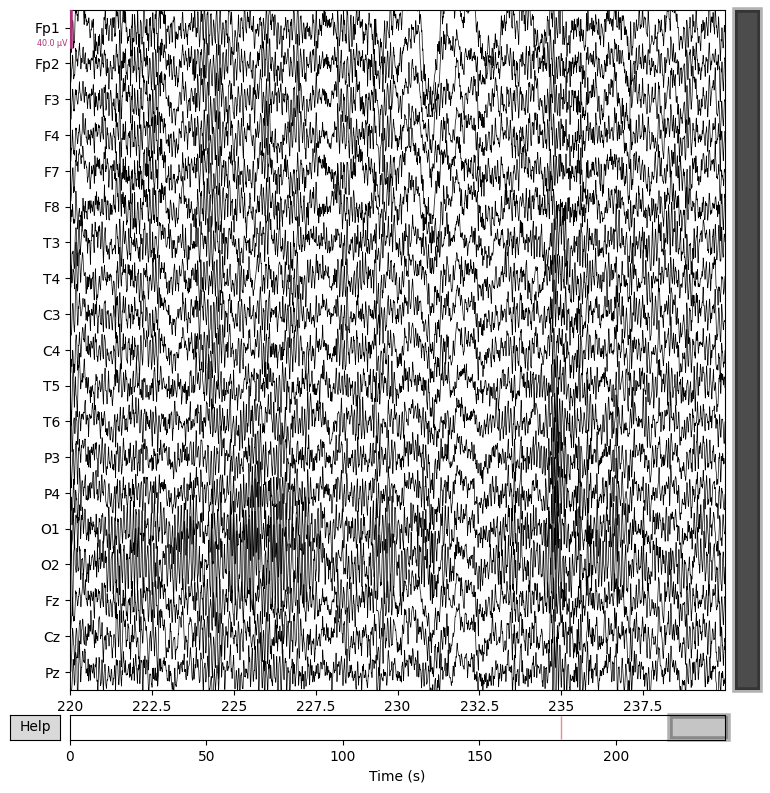

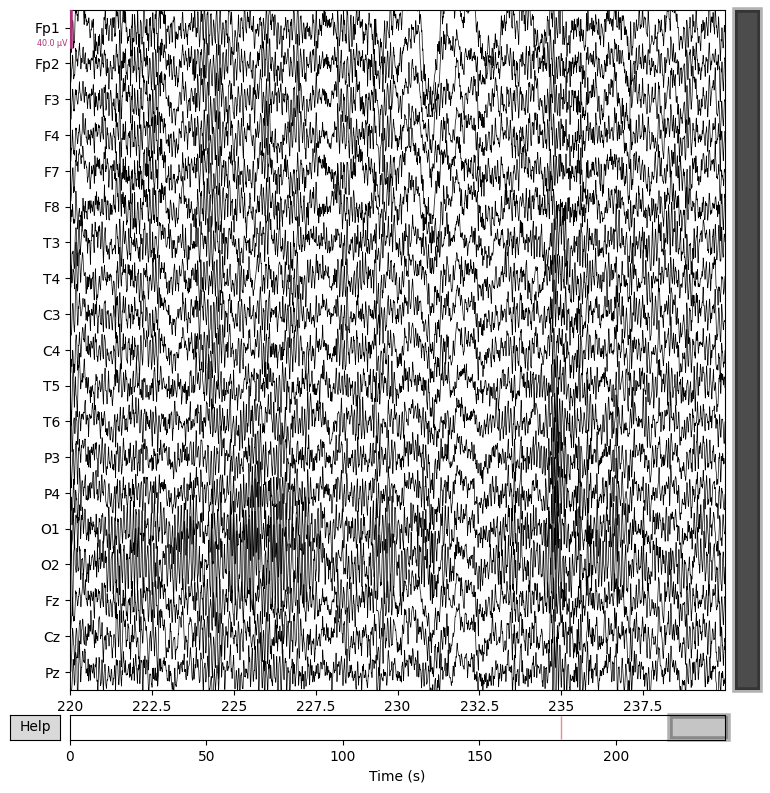

In [11]:
raw.plot(start=220, duration=21)